## Hypothesis
My physical activity increases as my education life intensifies.
* My walking speed increases as my headphone audio level increases.

In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import scipy.stats as stat
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
with open("apple_health_export/export.xml", "r") as f:
    my_data = et.parse(f)

# An example from the dataset
print(my_data.getroot()[6].attrib)
my_count = my_data.getroot()[6].attrib
print(my_count["type"], my_count["creationDate"], my_count["value"])

{'type': 'HKQuantityTypeIdentifierStepCount', 'sourceName': 'Onur’un iPhone’u', 'sourceVersion': '13.5.1', 'device': '<<HKDevice: 0x2805f4eb0>, name:iPhone, manufacturer:Apple Inc., model:iPhone, hardware:iPhone12,1, software:13.5.1>', 'unit': 'count', 'creationDate': '2020-08-29 11:33:43 +0300', 'startDate': '2020-08-29 11:23:16 +0300', 'endDate': '2020-08-29 11:32:13 +0300', 'value': '55'}
HKQuantityTypeIdentifierStepCount 2020-08-29 11:33:43 +0300 55


In [6]:
my_dict = my_data.getroot()
print(len(my_dict))

118441


In [7]:
record_list = [x.attrib for x in my_dict.iter('Record') if (x.attrib["type"] != "HKCategoryTypeIdentifierHeadphoneAudioExposureEvent") and (x.attrib["type"] != "HKQuantityTypeIdentifierBodyMass") and (x.attrib["type"] != "HKQuantityTypeIdentifierHeight")]

for record_dict in record_list:
    record_dict["value"] = float(record_dict["value"])

    if (record_dict["device"].find("software") != -1):
        record_dict["sourceVersion"] = record_dict["device"][(record_dict["device"].find("software") + 9):record_dict["device"].find(">", (record_dict["device"].find("software") + 9))]
        if (record_dict["sourceVersion"].count(".") > 1):
            record_dict["sourceVersion"] = float(record_dict["sourceVersion"][:record_dict["sourceVersion"].find(".", (record_dict["sourceVersion"].find(".") + 1))])
        else:
            record_dict["sourceVersion"] = float(record_dict["sourceVersion"])
            
    else:
        if (record_dict["sourceVersion"].count(".") > 1):
            record_dict["sourceVersion"] = float(record_dict["sourceVersion"][:record_dict["sourceVersion"].find(".", (record_dict["sourceVersion"].find(".") + 1))])
        else:
            record_dict["sourceVersion"] = float(record_dict["sourceVersion"])
    
    record_dict["deviceID"] = record_dict["device"][(record_dict["device"].find("HKDevice: ") + 10):(record_dict["device"].find(">"))]
    
    if (record_dict["type"] != "HKQuantityTypeIdentifierHeadphoneAudioExposure"):
        record_dict["device"] = record_dict["device"][(record_dict["device"].find("hardware:") + 9):(record_dict["device"].find("software") - 2)]
    else:
        record_dict["device"] = record_dict["device"][(record_dict["device"].find("name:") + 5):(record_dict["device"].find(",", record_dict["device"].find("name:")))]

## Identifier Types

Not to be considered:

* HKCategoryTypeIdentifierHeadphoneAudioExposureEvent
    * to be removed at the XML parsing - it does not contain any numeric value
* HKQuantityTypeIdentifierBodyMass
* HKQuantityTypeIdentifierHeight

To be considered:

* HKQuantityTypeIdentifierHeadphoneAudioExposure

* HKQuantityTypeIdentifierActiveEnergyBurned
* HKQuantityTypeIdentifierBasalEnergyBurned



* HKQuantityTypeIdentifierAppleWalkingSteadiness
* HKQuantityTypeIdentifierDistanceWalkingRunning
* HKQuantityTypeIdentifierFlightsClimbed
* HKQuantityTypeIdentifierStepCount
* HKQuantityTypeIdentifierWalkingAsymmetryPercentage
* HKQuantityTypeIdentifierWalkingDoubleSupportPercentage
* HKQuantityTypeIdentifierWalkingSpeed
* HKQuantityTypeIdentifierWalkingStepLength

Dataframe consisting of all the data

In [8]:
my_all_data = pd.DataFrame(record_list)

# Conversion of dates and times into datetime objects
my_all_data["creationDate"] = pd.to_datetime(my_all_data["creationDate"])
my_all_data["startDate"] = pd.to_datetime(my_all_data["startDate"])
my_all_data["endDate"] = pd.to_datetime(my_all_data["endDate"])

# Source name is "Onur'un iPhone'u" in all cases
my_all_data = my_all_data.drop(columns = ["sourceName"])

my_all_data

type  sourceVersion  \
0                    HKQuantityTypeIdentifierStepCount           13.5   
1                    HKQuantityTypeIdentifierStepCount           13.5   
2                    HKQuantityTypeIdentifierStepCount           13.5   
3                    HKQuantityTypeIdentifierStepCount           11.0   
4                    HKQuantityTypeIdentifierStepCount           11.0   
...                                                ...            ...   
117978  HKQuantityTypeIdentifierAppleWalkingSteadiness           17.0   
117979  HKQuantityTypeIdentifierAppleWalkingSteadiness           17.0   
117980  HKQuantityTypeIdentifierAppleWalkingSteadiness           17.0   
117981  HKQuantityTypeIdentifierAppleWalkingSteadiness           17.1   
117982  HKQuantityTypeIdentifierAppleWalkingSteadiness           17.1   

            device   unit              creationDate                 startDate  \
0       iPhone12,1  count 2020-08-29 11:33:43+03:00 2020-08-29 11:23:16+03:00   
1       iPhone12,1  count 2020-08-29 11:44:33+03:00 2020-08-29 11:32:15+03:00   
2       iPhone12,1  count 2020-08-29 11:54:40+03:00 2020-08-29 11:42:16+03:00   
3        iPhone9,3  count 2017-11-23 22:32:12+03:00 2017-11-23 22:20:45+03:00   
4        iPhone9,3  count 2017-11-24 08:21:36+03:00 2017-11-24 07:45:13+03:00   
...            ...    ...                       ...                       ...   
117978  iPhone12,1      % 2023-10-12 09:04:49+03:00 2023-10-05 03:00:00+03:00   
117979  iPhone12,1      % 2023-10-19 08:12:23+03:00 2023-10-12 03:00:00+03:00   
117980  iPhone12,1      % 2023-10-26 08:39:04+03:00 2023-10-19 03:00:00+03:00   
117981  iPhone12,1      % 2023-11-02 09:05:53+03:00 2023-10-26 03:00:00+03:00   
117982  iPhone12,1      % 2023-11-09 09:16:48+03:00 2023-11-02 03:00:00+03:00   

                         endDate  value     deviceID  
0      2020-08-29 11:32:13+03:00   55.0  0x2805f4eb0  
1      2020-08-29 11:42:16+03:00  667.0  0x2805f4eb0  
2      2020-08-29 11:48:59+03:00  501.0  0x2805f4eb0  
3      2017-11-23 22:22:34+03:00   22.0  0x2805f5270  
4      2017-11-24 07:55:11+03:00  122.0  0x2805f5270  
...                          ...    ...          ...  
117978 2023-10-12 03:00:00+03:00    1.0  0x280540500  
117979 2023-10-19 03:00:00+03:00    1.0  0x280540500  
117980 2023-10-26 03:00:00+03:00    1.0  0x280540500  
117981 2023-11-02 03:00:00+03:00    1.0  0x280540550  
117982 2023-11-09 03:00:00+03:00    1.0  0x2805405a0  

[117983 rows x 9 columns]

Dataframes directly related to physical activity

In [9]:
my_steps = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierStepCount"].reset_index().drop(columns = ["index"])
my_steps.head()

type  sourceVersion      device   unit  \
0  HKQuantityTypeIdentifierStepCount           13.5  iPhone12,1  count   
1  HKQuantityTypeIdentifierStepCount           13.5  iPhone12,1  count   
2  HKQuantityTypeIdentifierStepCount           13.5  iPhone12,1  count   
3  HKQuantityTypeIdentifierStepCount           11.0   iPhone9,3  count   
4  HKQuantityTypeIdentifierStepCount           11.0   iPhone9,3  count   

               creationDate                 startDate  \
0 2020-08-29 11:33:43+03:00 2020-08-29 11:23:16+03:00   
1 2020-08-29 11:44:33+03:00 2020-08-29 11:32:15+03:00   
2 2020-08-29 11:54:40+03:00 2020-08-29 11:42:16+03:00   
3 2017-11-23 22:32:12+03:00 2017-11-23 22:20:45+03:00   
4 2017-11-24 08:21:36+03:00 2017-11-24 07:45:13+03:00   

                    endDate  value     deviceID  
0 2020-08-29 11:32:13+03:00   55.0  0x2805f4eb0  
1 2020-08-29 11:42:16+03:00  667.0  0x2805f4eb0  
2 2020-08-29 11:48:59+03:00  501.0  0x2805f4eb0  
3 2017-11-23 22:22:34+03:00   22.0  0x2805f5270  
4 2017-11-24 07:55:11+03:00  122.0  0x2805f5270

In [10]:
my_distances = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierDistanceWalkingRunning"].reset_index().drop(columns = ["index"])
my_distances.head()

type  sourceVersion      device  \
0  HKQuantityTypeIdentifierDistanceWalkingRunning           13.5  iPhone12,1   
1  HKQuantityTypeIdentifierDistanceWalkingRunning           13.5  iPhone12,1   
2  HKQuantityTypeIdentifierDistanceWalkingRunning           13.5  iPhone12,1   
3  HKQuantityTypeIdentifierDistanceWalkingRunning           11.0   iPhone9,3   
4  HKQuantityTypeIdentifierDistanceWalkingRunning           11.0   iPhone9,3   

  unit              creationDate                 startDate  \
0   km 2020-08-29 11:33:43+03:00 2020-08-29 11:23:16+03:00   
1   km 2020-08-29 11:44:33+03:00 2020-08-29 11:32:15+03:00   
2   km 2020-08-29 11:54:40+03:00 2020-08-29 11:42:16+03:00   
3   km 2017-11-23 22:32:12+03:00 2017-11-23 22:20:45+03:00   
4   km 2017-11-24 08:21:36+03:00 2017-11-24 07:45:13+03:00   

                    endDate    value     deviceID  
0 2020-08-29 11:32:13+03:00  0.03644  0x2806c1090  
1 2020-08-29 11:42:16+03:00  0.47539  0x2806c1090  
2 2020-08-29 11:48:59+03:00  0.35122  0x2806c1090  
3 2017-11-23 22:22:34+03:00  0.00980  0x2806cc1e0  
4 2017-11-24 07:55:11+03:00  0.07920  0x2806cc1e0

In [11]:
my_climbed = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierFlightsClimbed"].reset_index().drop(columns = ["index"])
my_climbed.head()

type  sourceVersion      device   unit  \
0  HKQuantityTypeIdentifierFlightsClimbed           13.5  iPhone12,1  count   
1  HKQuantityTypeIdentifierFlightsClimbed           11.0   iPhone9,3  count   
2  HKQuantityTypeIdentifierFlightsClimbed           11.0   iPhone9,3  count   
3  HKQuantityTypeIdentifierFlightsClimbed           11.0   iPhone9,3  count   
4  HKQuantityTypeIdentifierFlightsClimbed           11.0   iPhone9,3  count   

               creationDate                 startDate  \
0 2020-08-29 12:01:30+03:00 2020-08-29 11:48:05+03:00   
1 2017-11-24 08:21:37+03:00 2017-11-24 08:08:41+03:00   
2 2017-11-24 16:37:17+03:00 2017-11-24 10:54:49+03:00   
3 2017-11-24 16:37:17+03:00 2017-11-24 12:31:57+03:00   
4 2017-11-24 16:37:17+03:00 2017-11-24 14:06:04+03:00   

                    endDate  value     deviceID  
0 2020-08-29 11:48:51+03:00    4.0  0x2806663f0  
1 2017-11-24 08:08:41+03:00    1.0  0x280666cb0  
2 2017-11-24 10:54:49+03:00    1.0  0x280666cb0  
3 2017-11-24 12:31:57+03:00    1.0  0x280666cb0  
4 2017-11-24 14:06:04+03:00    1.0  0x280666cb0

In [12]:
my_step_length = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierWalkingStepLength"].reset_index().drop(columns = ["index"])
my_step_length.head()

type  sourceVersion      device unit  \
0  HKQuantityTypeIdentifierWalkingStepLength           14.0  iPhone12,1   cm   
1  HKQuantityTypeIdentifierWalkingStepLength           14.0  iPhone12,1   cm   
2  HKQuantityTypeIdentifierWalkingStepLength           14.0  iPhone12,1   cm   
3  HKQuantityTypeIdentifierWalkingStepLength           14.0  iPhone12,1   cm   
4  HKQuantityTypeIdentifierWalkingStepLength           14.0  iPhone12,1   cm   

               creationDate                 startDate  \
0 2020-09-21 09:06:06+03:00 2020-09-21 08:55:43+03:00   
1 2020-09-21 10:32:19+03:00 2020-09-21 10:20:34+03:00   
2 2020-09-21 10:32:19+03:00 2020-09-21 10:22:17+03:00   
3 2020-09-21 13:01:57+03:00 2020-09-21 12:50:43+03:00   
4 2020-09-21 13:01:57+03:00 2020-09-21 12:51:06+03:00   

                    endDate  value     deviceID  
0 2020-09-21 08:56:55+03:00   84.0  0x2805402d0  
1 2020-09-21 10:20:50+03:00   82.0  0x2805402d0  
2 2020-09-21 10:22:26+03:00   90.0  0x2805402d0  
3 2020-09-21 12:50:47+03:00   72.0  0x2805402d0  
4 2020-09-21 12:52:19+03:00   74.0  0x2805402d0

In [13]:
my_walking_speed = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierWalkingSpeed"].reset_index().drop(columns = ["index"])
my_walking_speed.head()

type  sourceVersion      device   unit  \
0  HKQuantityTypeIdentifierWalkingSpeed           14.0  iPhone12,1  km/hr   
1  HKQuantityTypeIdentifierWalkingSpeed           14.0  iPhone12,1  km/hr   
2  HKQuantityTypeIdentifierWalkingSpeed           14.0  iPhone12,1  km/hr   
3  HKQuantityTypeIdentifierWalkingSpeed           14.0  iPhone12,1  km/hr   
4  HKQuantityTypeIdentifierWalkingSpeed           14.0  iPhone12,1  km/hr   

               creationDate                 startDate  \
0 2020-09-21 09:06:06+03:00 2020-09-21 08:55:43+03:00   
1 2020-09-21 10:32:19+03:00 2020-09-21 10:20:34+03:00   
2 2020-09-21 10:32:19+03:00 2020-09-21 10:22:17+03:00   
3 2020-09-21 13:01:57+03:00 2020-09-21 12:50:43+03:00   
4 2020-09-21 13:01:57+03:00 2020-09-21 12:51:06+03:00   

                    endDate  value     deviceID  
0 2020-09-21 08:56:55+03:00  6.336  0x280540190  
1 2020-09-21 10:20:50+03:00  6.120  0x280540190  
2 2020-09-21 10:22:26+03:00  6.876  0x280540190  
3 2020-09-21 12:50:47+03:00  4.176  0x280540190  
4 2020-09-21 12:52:19+03:00  4.824  0x280540190

In [14]:
my_walking_asymmetry = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierWalkingAsymmetryPercentage"].reset_index().drop(columns = ["index"])
my_walking_asymmetry.head()

type  sourceVersion  \
0  HKQuantityTypeIdentifierWalkingAsymmetryPercen...           14.0   
1  HKQuantityTypeIdentifierWalkingAsymmetryPercen...           14.0   
2  HKQuantityTypeIdentifierWalkingAsymmetryPercen...           14.0   
3  HKQuantityTypeIdentifierWalkingAsymmetryPercen...           14.0   
4  HKQuantityTypeIdentifierWalkingAsymmetryPercen...           14.0   

       device unit              creationDate                 startDate  \
0  iPhone12,1    % 2020-09-21 09:06:06+03:00 2020-09-21 08:55:43+03:00   
1  iPhone12,1    % 2020-09-21 10:32:19+03:00 2020-09-21 10:20:34+03:00   
2  iPhone12,1    % 2020-09-21 13:01:57+03:00 2020-09-21 12:51:06+03:00   
3  iPhone12,1    % 2020-09-22 12:17:56+03:00 2020-09-22 09:49:28+03:00   
4  iPhone12,1    % 2020-09-22 12:40:06+03:00 2020-09-22 12:18:35+03:00   

                    endDate  value     deviceID  
0 2020-09-21 08:56:55+03:00   0.00  0x280540190  
1 2020-09-21 10:20:50+03:00   0.07  0x280540190  
2 2020-09-21 12:52:19+03:00   0.00  0x280540190  
3 2020-09-22 09:50:48+03:00   0.00  0x280540190  
4 2020-09-22 12:18:59+03:00   0.00  0x280540190

In [15]:
my_walking_double_support = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierWalkingDoubleSupportPercentage"].reset_index().drop(columns = ["index"])
my_walking_double_support.head()

type  sourceVersion  \
0  HKQuantityTypeIdentifierWalkingDoubleSupportPe...           14.0   
1  HKQuantityTypeIdentifierWalkingDoubleSupportPe...           14.0   
2  HKQuantityTypeIdentifierWalkingDoubleSupportPe...           14.0   
3  HKQuantityTypeIdentifierWalkingDoubleSupportPe...           14.0   
4  HKQuantityTypeIdentifierWalkingDoubleSupportPe...           14.0   

       device unit              creationDate                 startDate  \
0  iPhone12,1    % 2020-09-21 09:06:06+03:00 2020-09-21 08:55:43+03:00   
1  iPhone12,1    % 2020-09-21 10:32:19+03:00 2020-09-21 10:20:34+03:00   
2  iPhone12,1    % 2020-09-21 10:32:19+03:00 2020-09-21 10:22:17+03:00   
3  iPhone12,1    % 2020-09-21 13:01:57+03:00 2020-09-21 12:50:43+03:00   
4  iPhone12,1    % 2020-09-21 13:01:57+03:00 2020-09-21 12:51:06+03:00   

                    endDate  value     deviceID  
0 2020-09-21 08:56:55+03:00  0.228  0x2805e6cb0  
1 2020-09-21 10:20:50+03:00  0.236  0x2805e6cb0  
2 2020-09-21 10:22:26+03:00  0.225  0x2805e6cb0  
3 2020-09-21 12:50:47+03:00  0.306  0x2805e6cb0  
4 2020-09-21 12:52:19+03:00  0.275  0x2805e6cb0

In [16]:
my_walking_steady = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierAppleWalkingSteadiness"].reset_index().drop(columns = ["index"])
my_walking_steady.head()

type  sourceVersion      device  \
0  HKQuantityTypeIdentifierAppleWalkingSteadiness           16.0  iPhone12,1   
1  HKQuantityTypeIdentifierAppleWalkingSteadiness           16.0  iPhone12,1   
2  HKQuantityTypeIdentifierAppleWalkingSteadiness           16.0  iPhone12,1   
3  HKQuantityTypeIdentifierAppleWalkingSteadiness           16.0  iPhone12,1   
4  HKQuantityTypeIdentifierAppleWalkingSteadiness           16.0  iPhone12,1   

  unit              creationDate                 startDate  \
0    % 2022-09-16 22:58:11+03:00 2022-06-25 03:00:00+03:00   
1    % 2022-09-16 22:58:11+03:00 2022-07-02 03:00:00+03:00   
2    % 2022-09-16 22:58:11+03:00 2022-07-10 03:00:00+03:00   
3    % 2022-09-16 22:58:11+03:00 2022-07-17 03:00:00+03:00   
4    % 2022-09-16 22:58:11+03:00 2022-07-24 03:00:00+03:00   

                    endDate     value     deviceID  
0 2022-07-02 03:00:00+03:00  1.000000  0x280540190  
1 2022-07-09 03:00:00+03:00  1.000000  0x280540190  
2 2022-07-17 03:00:00+03:00  1.000000  0x280540190  
3 2022-07-24 03:00:00+03:00  0.945581  0x280540190  
4 2022-07-31 03:00:00+03:00  0.805529  0x280540190

Dataframes related to burned energy statistics

In [17]:
my_active_energy = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierActiveEnergyBurned"].reset_index().drop(columns = ['index'])
my_active_energy.head()

type  sourceVersion      device  \
0  HKQuantityTypeIdentifierActiveEnergyBurned           16.0  iPhone12,1   
1  HKQuantityTypeIdentifierActiveEnergyBurned           16.0  iPhone12,1   
2  HKQuantityTypeIdentifierActiveEnergyBurned           16.0  iPhone12,1   
3  HKQuantityTypeIdentifierActiveEnergyBurned           16.0  iPhone12,1   
4  HKQuantityTypeIdentifierActiveEnergyBurned           16.0  iPhone12,1   

   unit              creationDate                 startDate  \
0  kcal 2022-09-16 22:19:16+03:00 2022-09-16 00:01:22+03:00   
1  kcal 2022-09-16 22:19:16+03:00 2022-09-16 00:15:33+03:00   
2  kcal 2022-09-16 22:19:16+03:00 2022-09-16 09:31:12+03:00   
3  kcal 2022-09-16 22:19:16+03:00 2022-09-16 10:37:43+03:00   
4  kcal 2022-09-16 22:19:16+03:00 2022-09-16 10:55:21+03:00   

                    endDate  value     deviceID  
0 2022-09-16 00:02:04+03:00  0.078  0x2806f0eb0  
1 2022-09-16 00:15:44+03:00  0.038  0x2806f0eb0  
2 2022-09-16 09:39:46+03:00  0.098  0x2806f0eb0  
3 2022-09-16 10:44:24+03:00  0.638  0x2806f0eb0  
4 2022-09-16 10:58:32+03:00  0.686  0x2806f0eb0

In [18]:
my_basal_energy = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierBasalEnergyBurned"].reset_index().drop(columns = ['index'])
my_basal_energy.head()

type  sourceVersion      device  unit  \
0  HKQuantityTypeIdentifierBasalEnergyBurned           16.0  iPhone12,1  kcal   
1  HKQuantityTypeIdentifierBasalEnergyBurned           16.0  iPhone12,1  kcal   
2  HKQuantityTypeIdentifierBasalEnergyBurned           16.0  iPhone12,1  kcal   
3  HKQuantityTypeIdentifierBasalEnergyBurned           16.0  iPhone12,1  kcal   
4  HKQuantityTypeIdentifierBasalEnergyBurned           16.0  iPhone12,1  kcal   

               creationDate                 startDate  \
0 2022-09-16 22:19:16+03:00 2022-09-15 22:19:01+03:00   
1 2022-09-16 22:19:16+03:00 2022-09-15 22:34:05+03:00   
2 2022-09-16 22:19:16+03:00 2022-09-15 22:49:09+03:00   
3 2022-09-16 22:19:16+03:00 2022-09-15 23:04:13+03:00   
4 2022-09-16 22:19:16+03:00 2022-09-15 23:18:47+03:00   

                    endDate   value     deviceID  
0 2022-09-15 22:34:05+03:00  17.963  0x2806c0190  
1 2022-09-15 22:49:09+03:00  17.965  0x2806c0190  
2 2022-09-15 23:04:13+03:00  17.954  0x2806c0190  
3 2022-09-15 23:18:47+03:00  17.351  0x2806c0190  
4 2022-09-15 23:33:41+03:00  17.758  0x2806c0190

Dataframe related to headphone audio statistics

In [19]:
my_headphone_audio = my_all_data[my_all_data["type"] == "HKQuantityTypeIdentifierHeadphoneAudioExposure"].reset_index().drop(columns = ['index'])
my_headphone_audio.head()

type  sourceVersion   device  \
0  HKQuantityTypeIdentifierHeadphoneAudioExposure           13.1  EarPods   
1  HKQuantityTypeIdentifierHeadphoneAudioExposure           13.1  EarPods   
2  HKQuantityTypeIdentifierHeadphoneAudioExposure           13.1  EarPods   
3  HKQuantityTypeIdentifierHeadphoneAudioExposure           13.1  EarPods   
4  HKQuantityTypeIdentifierHeadphoneAudioExposure           13.1  EarPods   

     unit              creationDate                 startDate  \
0  dBASPL 2019-10-01 23:39:10+03:00 2019-10-01 23:29:23+03:00   
1  dBASPL 2019-10-01 23:53:20+03:00 2019-10-01 23:42:19+03:00   
2  dBASPL 2019-10-01 23:53:20+03:00 2019-10-01 23:51:48+03:00   
3  dBASPL 2019-10-01 23:53:20+03:00 2019-10-01 23:51:50+03:00   
4  dBASPL 2019-10-01 23:59:44+03:00 2019-10-01 23:52:46+03:00   

                    endDate    value     deviceID  
0 2019-10-01 23:38:40+03:00  82.5818  0x28065ead0  
1 2019-10-01 23:51:47+03:00  83.0852  0x28065ead0  
2 2019-10-01 23:51:51+03:00  84.4894  0x28065ead0  
3 2019-10-01 23:52:24+03:00  83.5434  0x28065ead0  
4 2019-10-01 23:56:38+03:00  76.4813  0x28065ead0

## Exploratory data analysis of the dataframes

The dataframe containing all the data

In [20]:
print(my_all_data.shape, "\n")
print(my_all_data.dtypes)
my_all_data.describe()

(117983, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion          value
count  117983.000000  117983.000000
mean       14.714384      45.667557
std         1.788097     102.935253
min        11.000000       0.000000
25%        13.400000       0.213000
50%        15.100000      10.000000
75%        16.200000      69.000000
max        17.100000   11094.000000

Dataframes directly related to physical activity

In [21]:
print(my_steps.shape, "\n")
print(my_steps.dtypes)
my_steps.describe()

(24049, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion         value
count   24049.000000  24049.000000
mean       13.531902    121.505801
std         1.780045    201.071968
min        11.000000      1.000000
25%        12.100000     13.000000
50%        13.300000     34.000000
75%        15.100000    154.000000
max        17.100000  11094.000000

In [22]:
print(my_distances.shape, "\n")
print(my_distances.dtypes)
my_distances.describe()

(23992, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion         value
count   23992.000000  23992.000000
mean       13.533053      0.085136
std         1.781029      0.146155
min        11.000000      0.000390
25%        12.100000      0.008880
50%        13.300000      0.022840
75%        15.100000      0.103450
max        17.100000      7.895340

In [23]:
print(my_climbed.shape, "\n")
print(my_climbed.dtypes)
my_climbed.describe()

(4888, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    4888.000000  4888.000000
mean       12.988768     1.939444
std         1.782392     1.443292
min        11.000000     1.000000
25%        11.300000     1.000000
50%        12.300000     1.000000
75%        14.400000     3.000000
max        17.100000    18.000000

In [24]:
print(my_step_length.shape, "\n")
print(my_step_length.dtypes)
my_step_length.describe()

(6433, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    6433.000000  6433.000000
mean       15.610229    74.494482
std         0.871119    14.136979
min        14.000000    25.000000
25%        15.000000    64.000000
50%        15.600000    74.000000
75%        16.200000    85.000000
max        17.100000   136.000000

In [25]:
print(my_walking_speed.shape, "\n")
print(my_walking_speed.dtypes)
my_walking_speed.describe()

(6433, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    6433.000000  6433.000000
mean       15.610229     4.838903
std         0.871119     1.376157
min        14.000000     1.548000
25%        15.000000     3.708000
50%        15.600000     4.788000
75%        16.200000     6.048000
max        17.100000     8.136000

In [26]:
print(my_walking_asymmetry.shape, "\n")
print(my_walking_asymmetry.dtypes)
my_walking_asymmetry.describe()

(2836, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    2836.000000  2836.000000
mean       15.936953     0.070339
std         0.807532     0.179761
min        14.000000     0.000000
25%        15.400000     0.000000
50%        16.100000     0.000000
75%        16.500000     0.040000
max        17.100000     1.000000

In [27]:
print(my_walking_double_support.shape, "\n")
print(my_walking_double_support.dtypes)
my_walking_double_support.describe()

(4528, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    4528.000000  4528.000000
mean       15.821798     0.269955
std         0.863544     0.033310
min        14.000000     0.172000
25%        15.200000     0.241000
50%        16.100000     0.268000
75%        16.500000     0.298000
max        17.100000     0.364000

In [28]:
print(my_walking_steady.shape, "\n")
print(my_walking_steady.dtypes)
my_walking_steady.describe()

(53, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion      value
count      53.000000  53.000000
mean       16.305660   0.995304
std         0.335362   0.027600
min        16.000000   0.805529
25%        16.000000   1.000000
50%        16.200000   1.000000
75%        16.500000   1.000000
max        17.100000   1.000000

Dataframes related to burned energy statistics

In [29]:
print(my_active_energy.shape, "\n")
print(my_active_energy.dtypes)
my_active_energy.describe()

(7140, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion        value
count    7140.000000  7140.000000
mean       16.390308     3.107266
std         0.319552     7.728980
min        16.000000     0.001000
25%        16.100000     0.035000
50%        16.300000     0.080000
75%        16.600000     1.298750
max        17.100000    87.983000

In [30]:
print(my_basal_energy.shape, "\n")
print(my_basal_energy.dtypes)
my_basal_energy.describe()

(19610, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion         value
count   19610.000000  19610.000000
mean       16.377292     38.663243
std         0.310360     30.811339
min        16.000000      0.203000
25%        16.100000     11.454250
50%        16.300000     26.253000
75%        16.500000     74.805000
max        17.100000    147.352000

Dataframe related to headphone audio statistics

In [31]:
print(my_headphone_audio.shape, "\n")
print(my_headphone_audio.dtypes)
my_headphone_audio.describe()

(18021, 9) 

type                                object
sourceVersion                      float64
device                              object
unit                                object
creationDate     datetime64[ns, UTC+03:00]
startDate        datetime64[ns, UTC+03:00]
endDate          datetime64[ns, UTC+03:00]
value                              float64
deviceID                            object
dtype: object


sourceVersion         value
count   18021.000000  18021.000000
mean       14.744753     64.490399
std         0.929702     21.451476
min        13.100000      0.000000
25%        14.300000     55.232000
50%        14.600000     67.173400
75%        15.500000     80.299100
max        17.100000    102.826000

## Visualizations of the categorical dataframes

### Histograms of the categorical dataframes

Dataframes directly related to physical activity

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


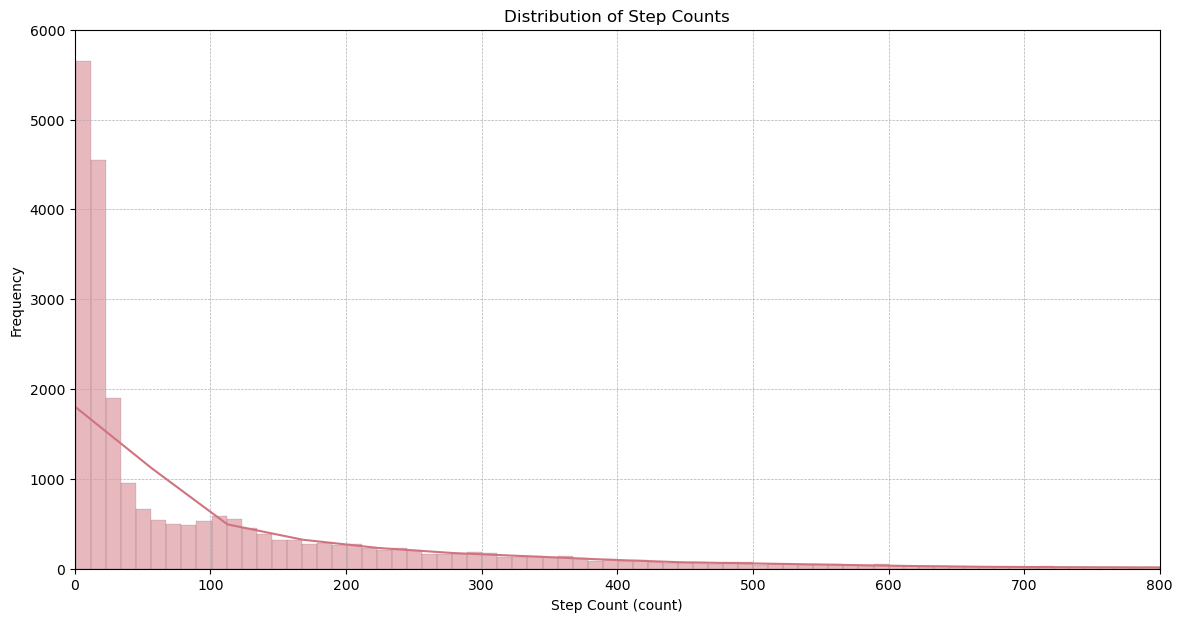

In [32]:
plt.figure(figsize = (14, 7))
sns.histplot(my_steps["value"], kde = True, bins = 1000, color = "#d0737f")
plt.title('Distribution of Step Counts')
plt.xlim(0, 800)
plt.ylim(0, 6000)
plt.xlabel('Step Count (' + my_steps["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


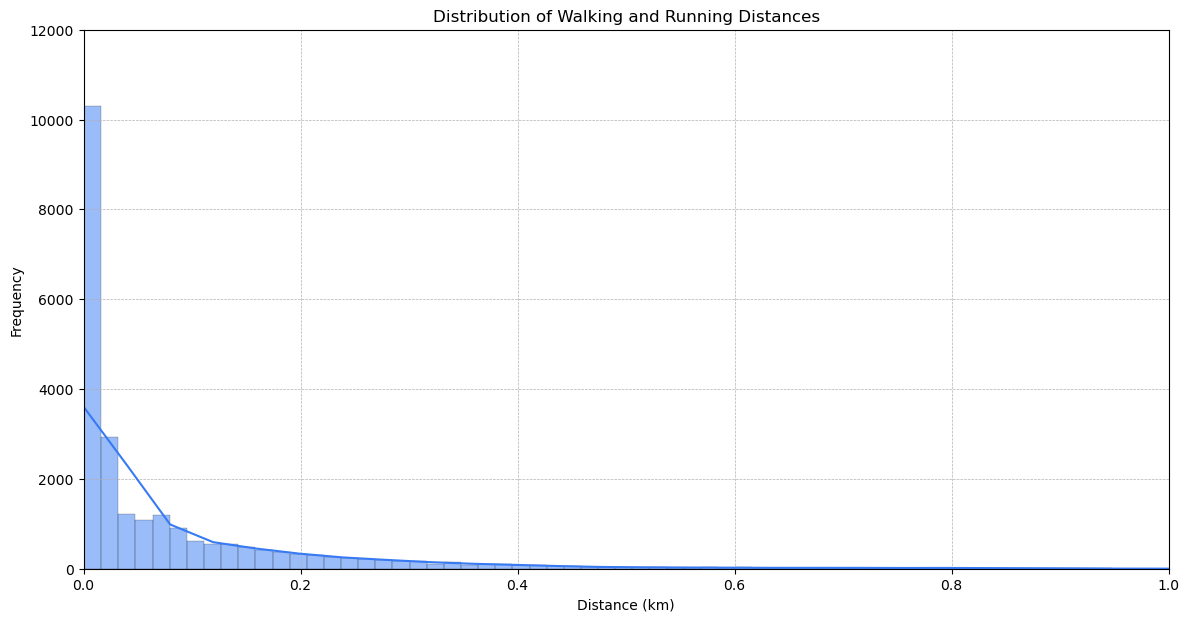

In [33]:
plt.figure(figsize = (14, 7))
sns.histplot(my_distances["value"], kde = True, bins = 500, color = "#377af3")
plt.title('Distribution of Walking and Running Distances')
plt.xlim(0, 1)
plt.ylim(0, 12000)
plt.xlabel('Distance (' + my_distances["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


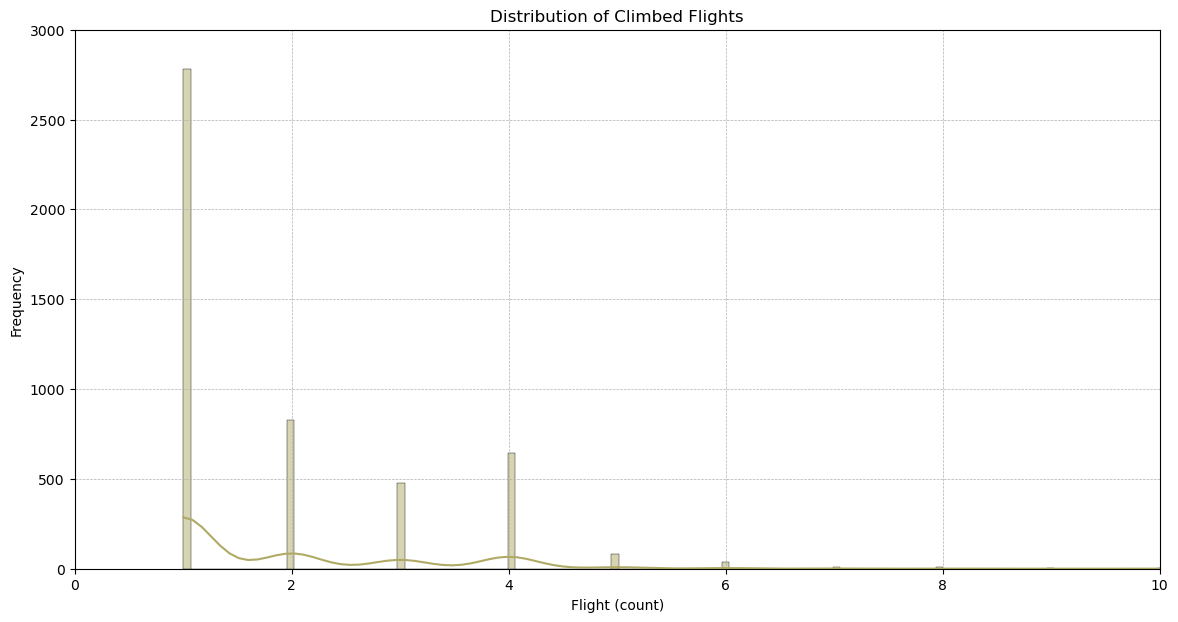

In [34]:
plt.figure(figsize = (14, 7))
sns.histplot(my_climbed["value"], kde = True, bins = 250, color = "#afaa65")
plt.title("Distribution of Climbed Flights")
plt.xlim(0, 10)
plt.ylim(0, 3000)
plt.xlabel('Flight (' + my_climbed["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


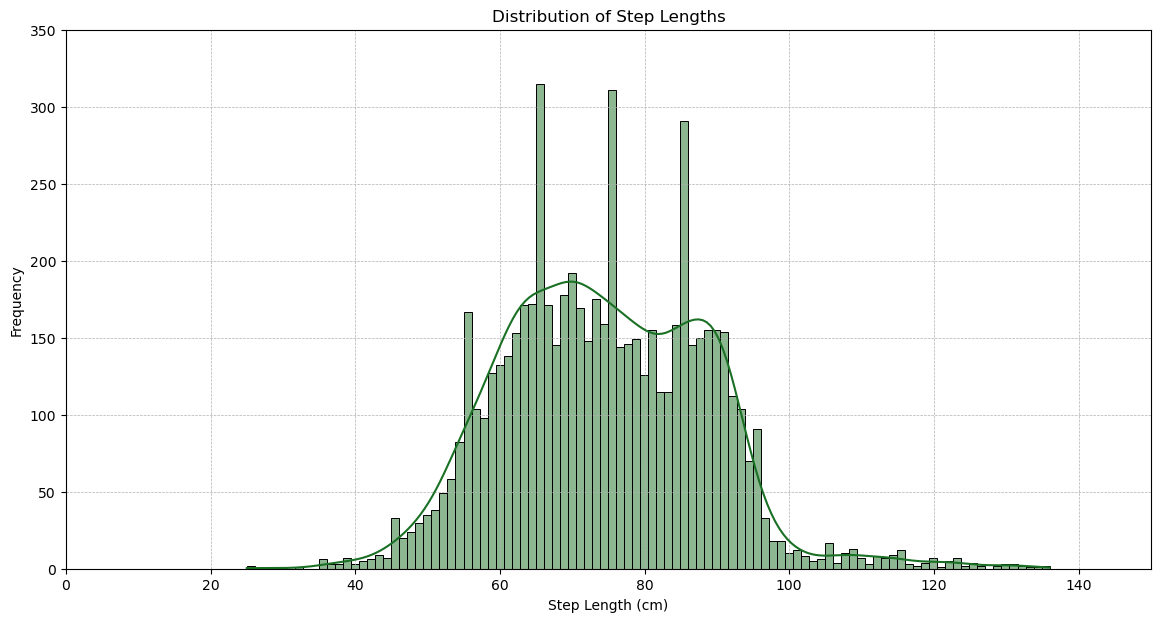

In [35]:
plt.figure(figsize = (14, 7))
sns.histplot(my_step_length["value"], kde = True, bins = 100, color = "#1a7024")
plt.title('Distribution of Step Lengths')
plt.xlim(0, 150)
plt.ylim(0, 350)
plt.xlabel('Step Length (' + my_step_length["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


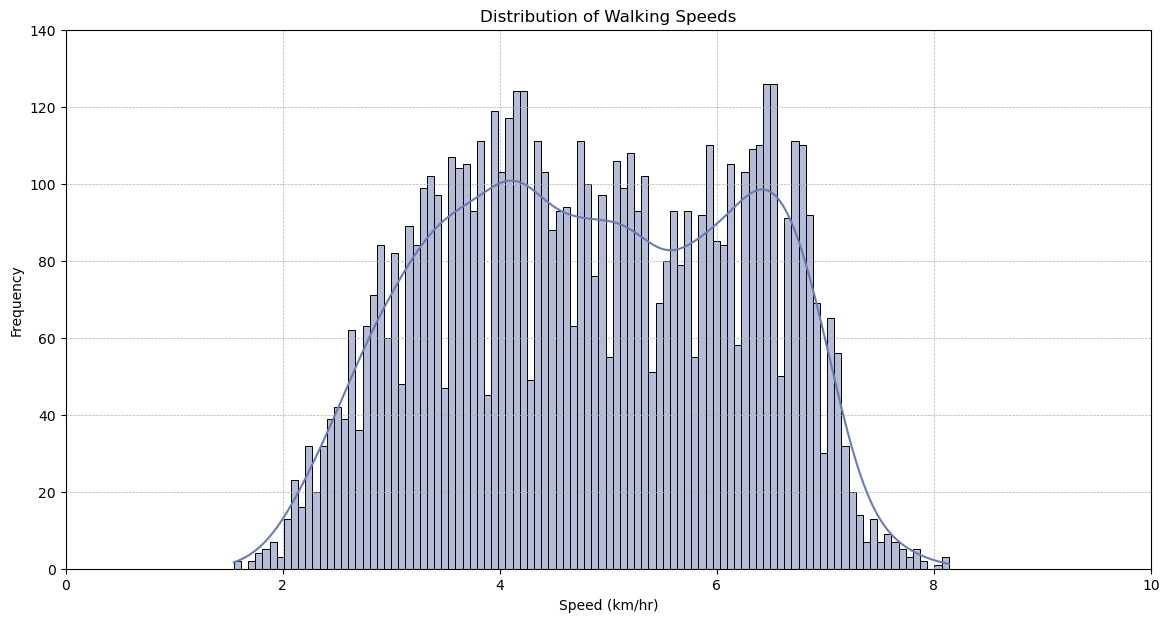

In [36]:
plt.figure(figsize = (14, 7))
sns.histplot(my_walking_speed["value"], kde = True, bins = 100, color = "#6b7bb3")
plt.title('Distribution of Walking Speeds')
plt.xlim(0, 10)
plt.ylim(0, 140)
plt.xlabel('Speed (' + my_walking_speed["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


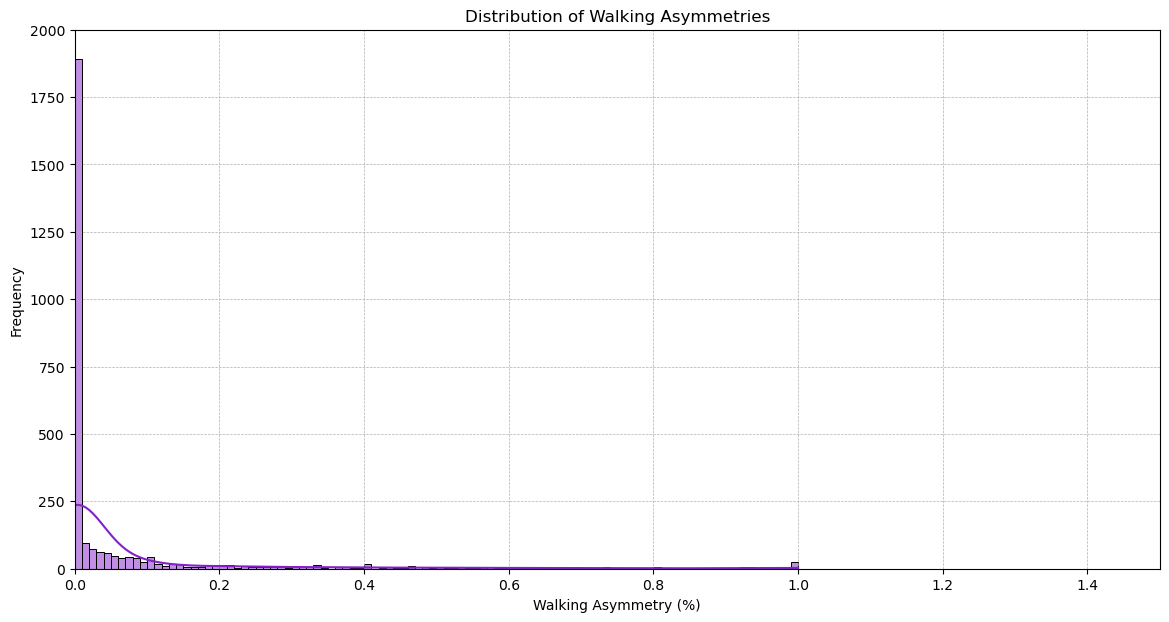

In [37]:
plt.figure(figsize = (14, 7))
sns.histplot(my_walking_asymmetry["value"], kde = True, bins = 100, color = "#8320c9")
plt.title('Distribution of Walking Asymmetries')
plt.xlim(0, 1.5)
plt.ylim(0, 2000)
plt.xlabel('Walking Asymmetry (' + my_walking_asymmetry["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


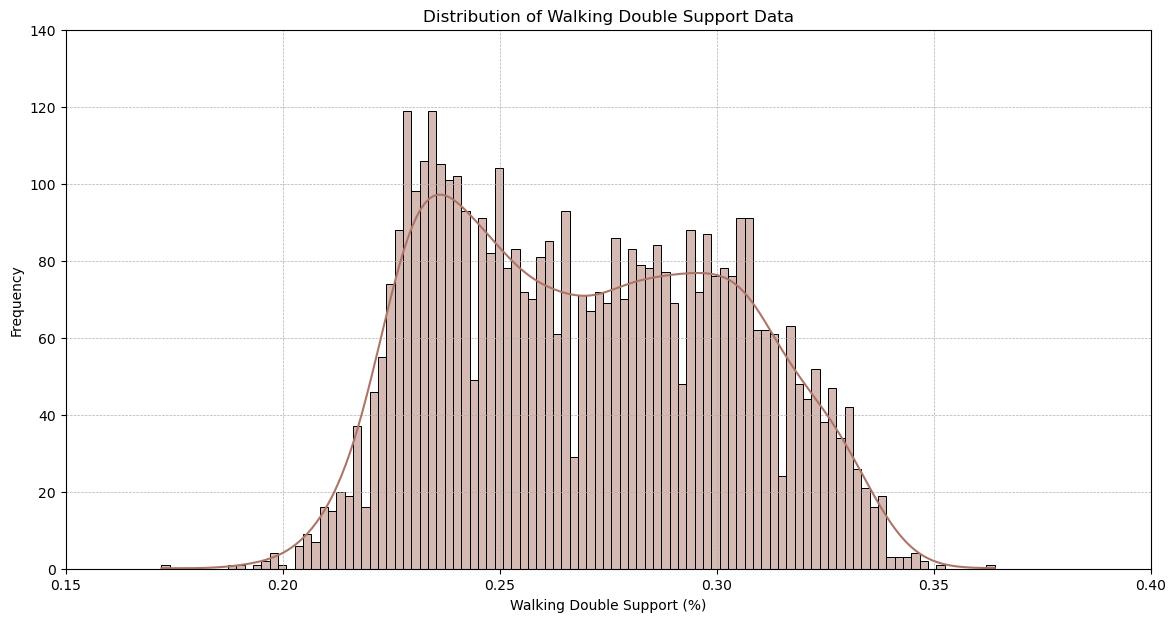

In [38]:
plt.figure(figsize = (14, 7))
sns.histplot(my_walking_double_support["value"], kde = True, bins = 100, color = "#ac7568")
plt.title('Distribution of Walking Double Support Data')
plt.xlim(0.15, 0.4)
plt.ylim(0, 140)
plt.xlabel('Walking Double Support (' + my_walking_double_support["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


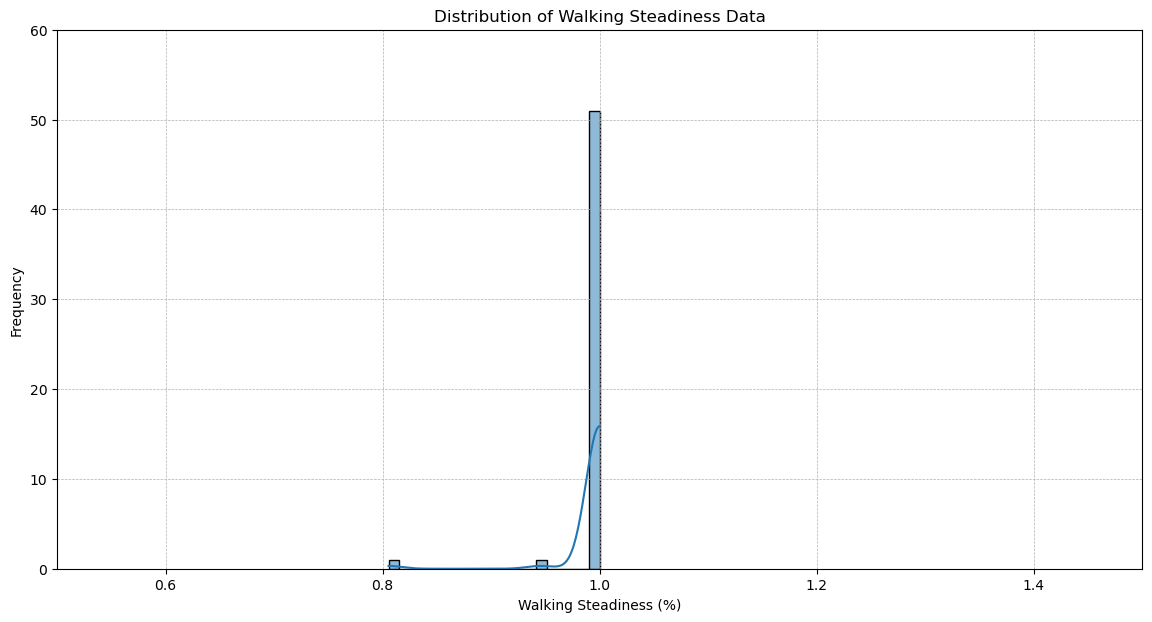

In [39]:
plt.figure(figsize = (14, 7))
sns.histplot(my_walking_steady["value"], kde = True, bins = 20)
plt.title('Distribution of Walking Steadiness Data')
plt.xlim(0.5, 1.5)
plt.ylim(0, 60)
plt.xlabel('Walking Steadiness (' + my_walking_steady["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Dataframes related to burned energy statistics

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


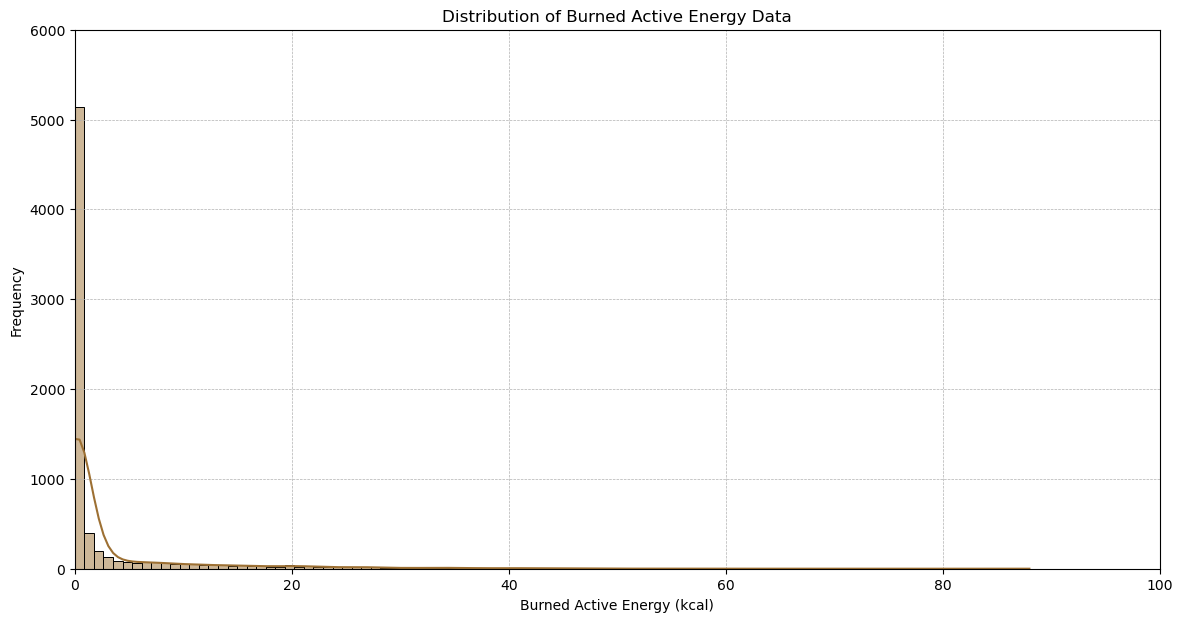

In [40]:
plt.figure(figsize = (14, 7))
sns.histplot(my_active_energy["value"], kde = True, bins = 100, color = "#9d7033")
plt.title('Distribution of Burned Active Energy Data')
plt.xlim(0, 100)
plt.ylim(0, 6000)
plt.xlabel('Burned Active Energy (' + my_active_energy["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


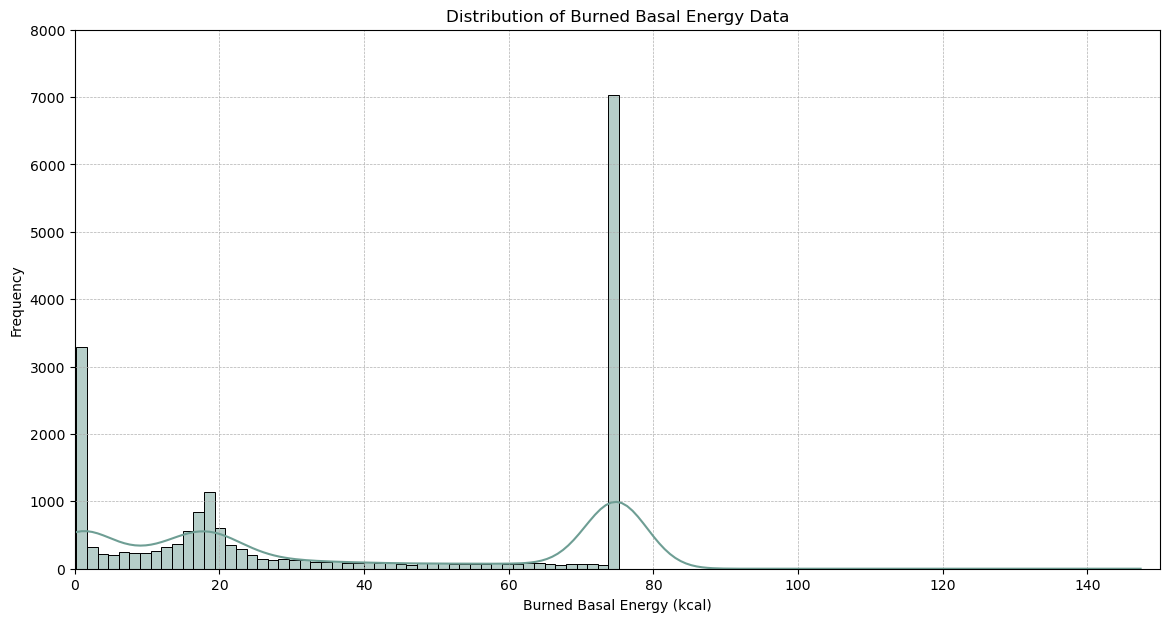

In [41]:
plt.figure(figsize = (14, 7))
sns.histplot(my_basal_energy["value"], kde = True, bins = 100, color = "#6e9e94")
plt.title('Distribution of Burned Basal Energy Data')
plt.xlim(0, 150)
plt.ylim(0, 8000)
plt.xlabel('Burned Basal Energy (' + my_basal_energy["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Dataframes related to headphone audio statistics

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


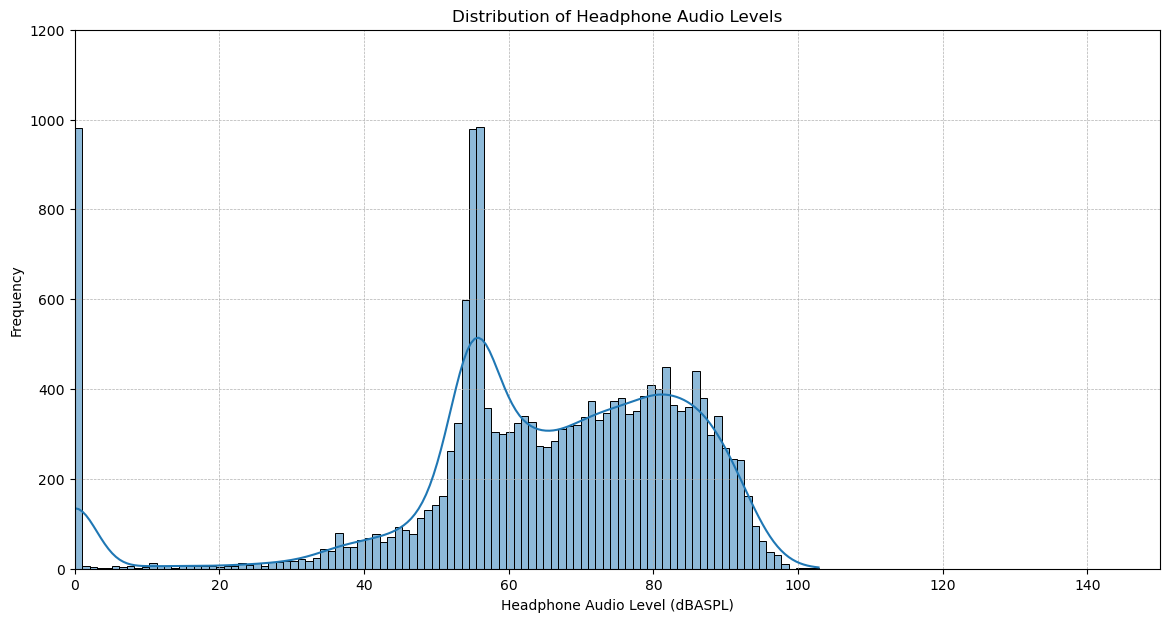

In [42]:
plt.figure(figsize = (14, 7))
sns.histplot(my_headphone_audio["value"], kde = True, bins = 100)
plt.title('Distribution of Headphone Audio Levels')
plt.xlim(0, 150)
plt.ylim(0, 1200)
plt.xlabel('Headphone Audio Level (' + my_headphone_audio["unit"][0] + ")")
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Line charts demonstrating the change of data over time

Dataframes directly related to physical activity

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


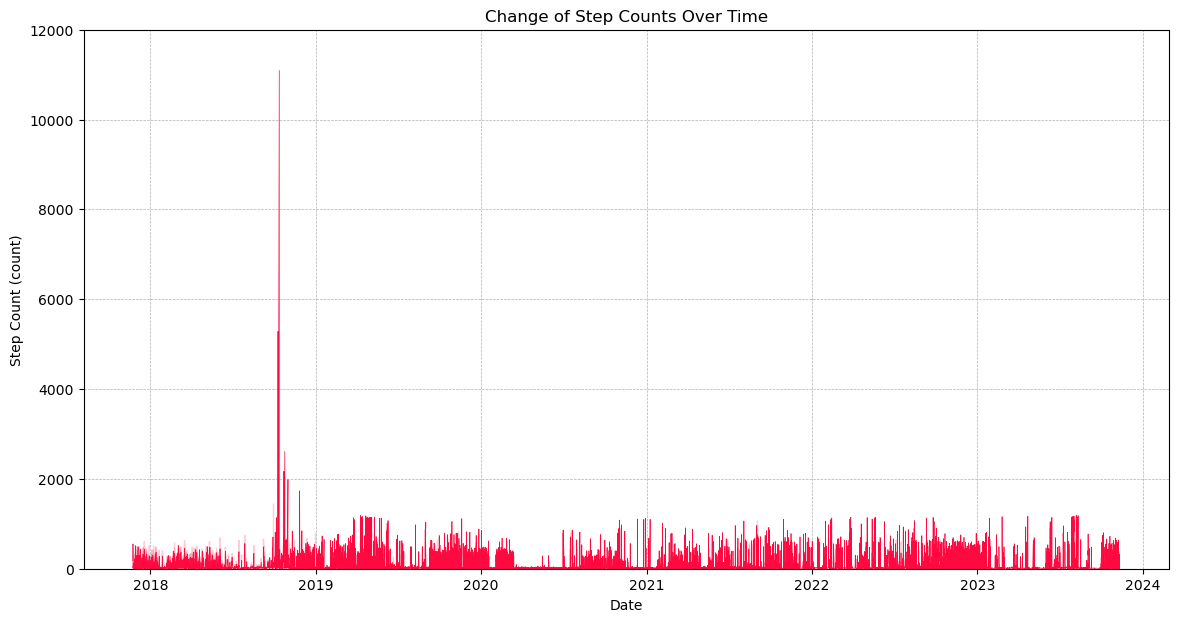

In [43]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_steps["creationDate"], y = my_steps["value"], color = "#ff0940", linewidth = 0.5)
plt.title('Change of Step Counts Over Time')
plt.ylim(0, 12000)
plt.xlabel('Date')
plt.ylabel('Step Count (' + my_steps["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


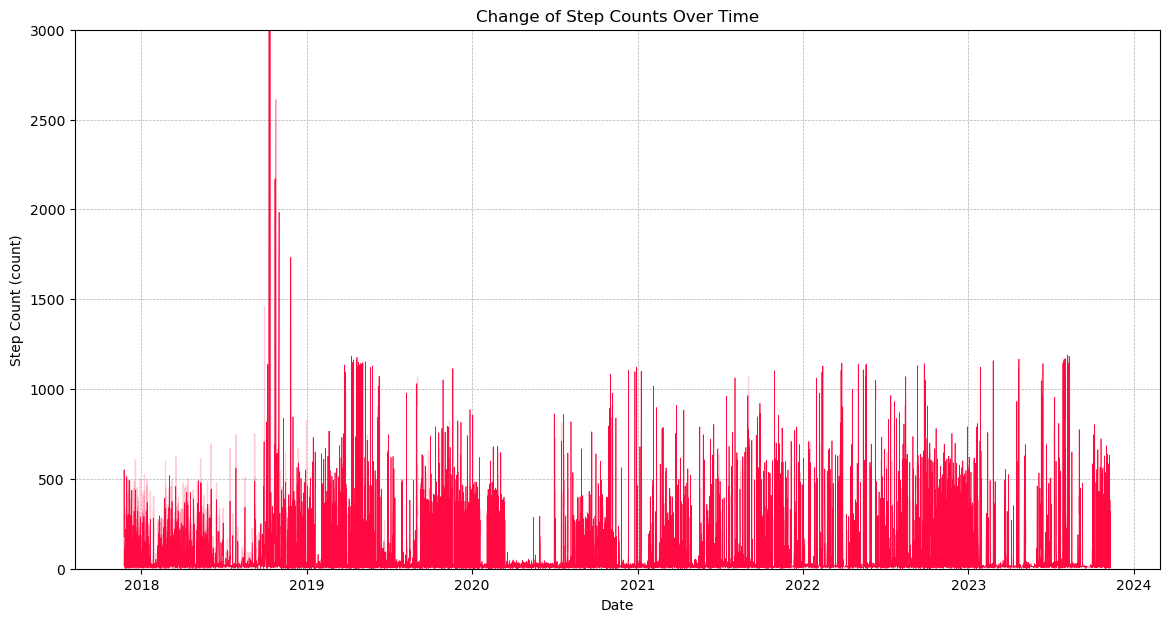

In [44]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_steps["creationDate"], y = my_steps["value"], color = "#ff0940", linewidth = 0.5)
plt.title('Change of Step Counts Over Time')
plt.ylim(0, 3000)
plt.xlabel('Date')
plt.ylabel('Step Count (' + my_steps["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


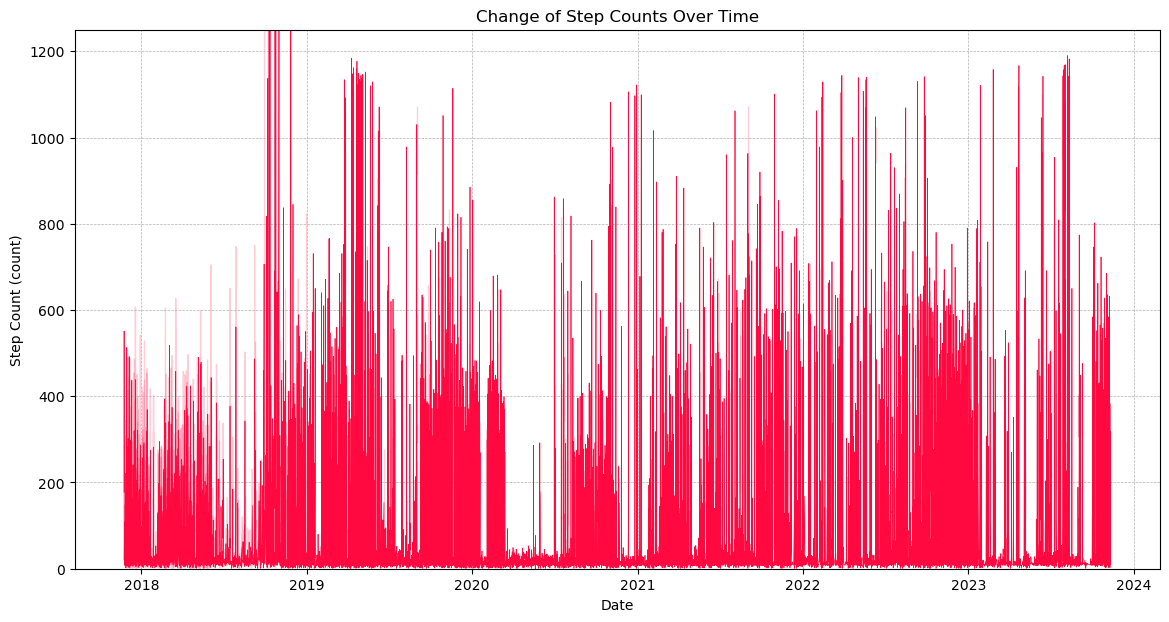

In [45]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_steps["creationDate"], y = my_steps["value"], color = "#ff0940", linewidth = 0.5)
plt.title('Change of Step Counts Over Time')
plt.ylim(0, 1250)
plt.xlabel('Date')
plt.ylabel('Step Count (' + my_steps["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


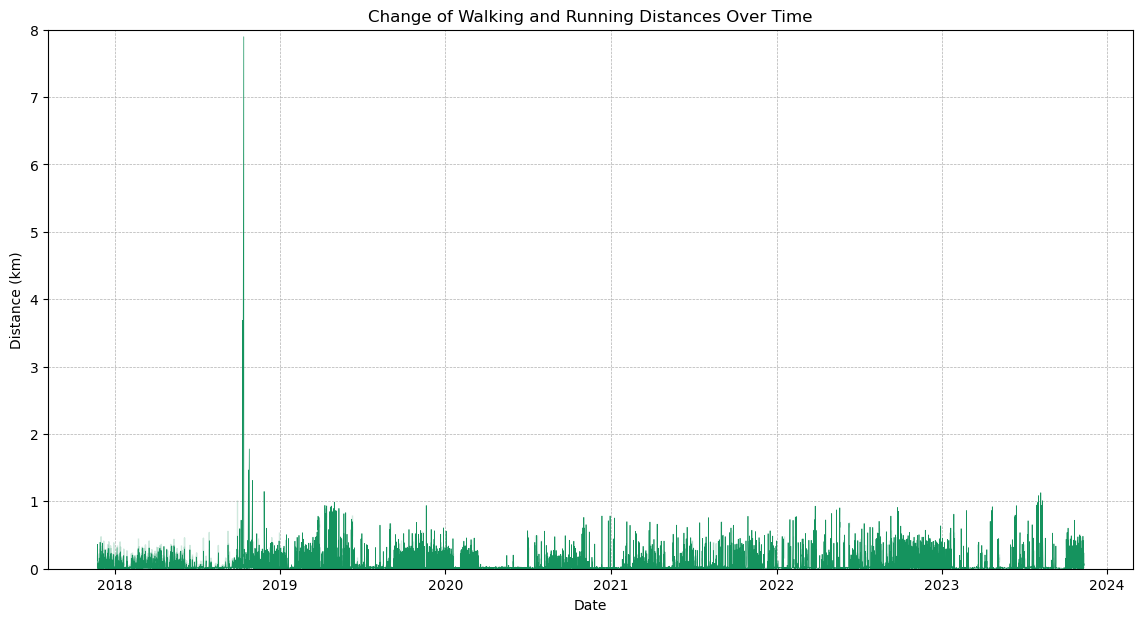

In [46]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_distances["creationDate"], y = my_distances["value"], color = "#15935e", linewidth = 0.5)
plt.title('Change of Walking and Running Distances Over Time')
plt.ylim(0, 8)
plt.xlabel('Date')
plt.ylabel('Distance (' + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


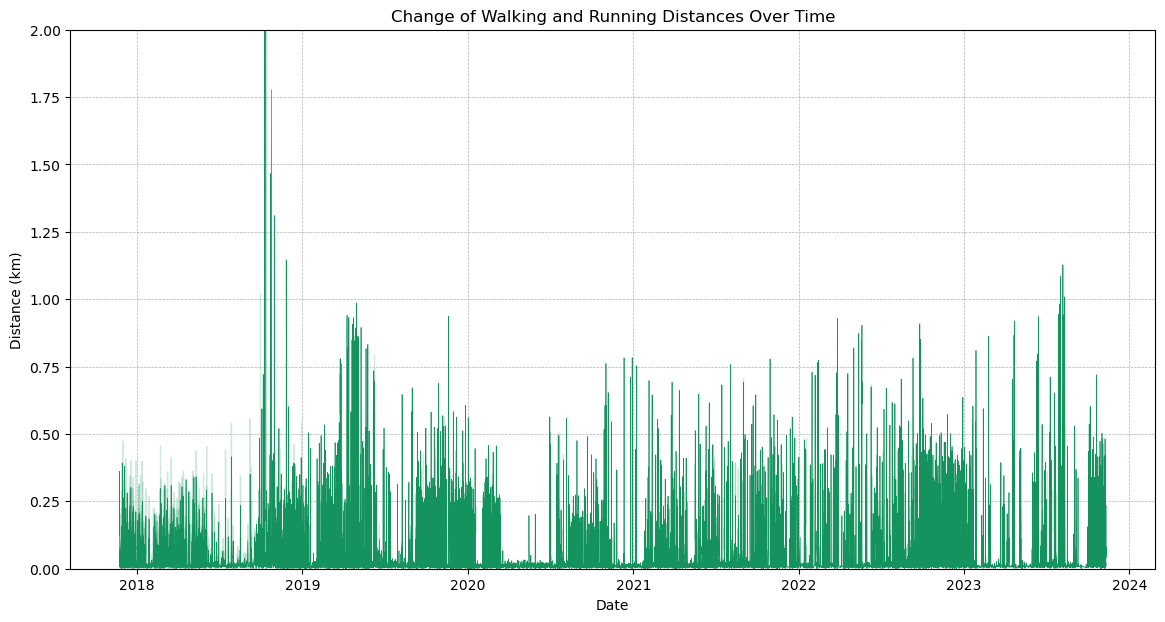

In [47]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_distances["creationDate"], y = my_distances["value"], color = "#15935e", linewidth = 0.5)
plt.title('Change of Walking and Running Distances Over Time')
plt.ylim(0, 2)
plt.xlabel('Date')
plt.ylabel('Distance (' + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


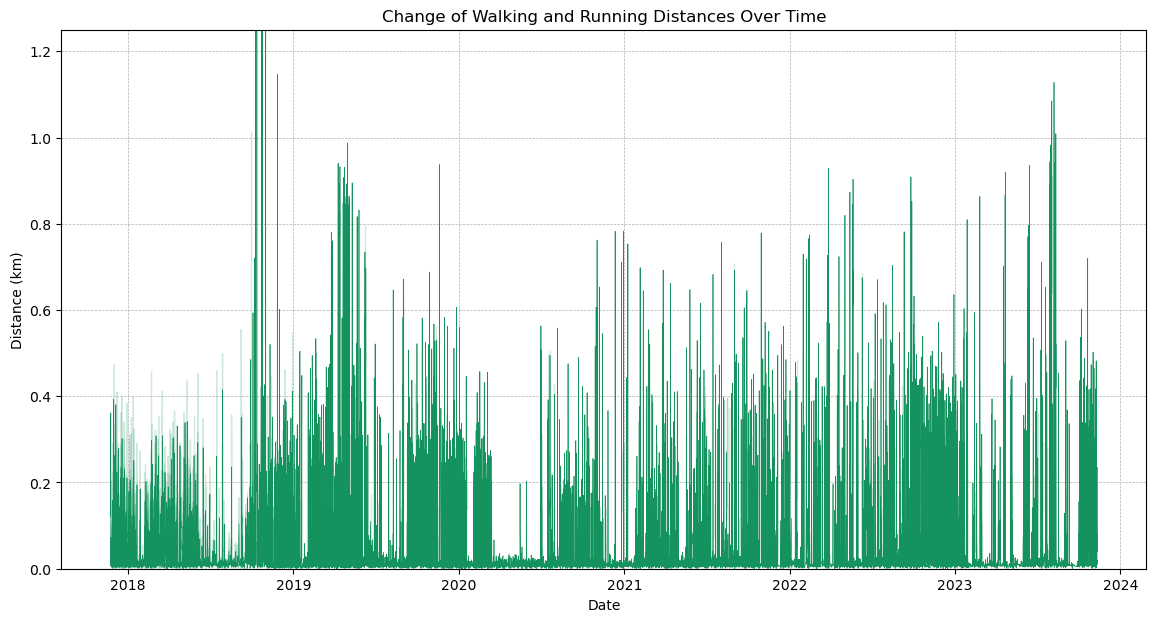

In [48]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_distances["creationDate"], y = my_distances["value"], color = "#15935e", linewidth = 0.5)
plt.title('Change of Walking and Running Distances Over Time')
plt.ylim(0, 1.25)
plt.xlabel('Date')
plt.ylabel('Distance (' + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


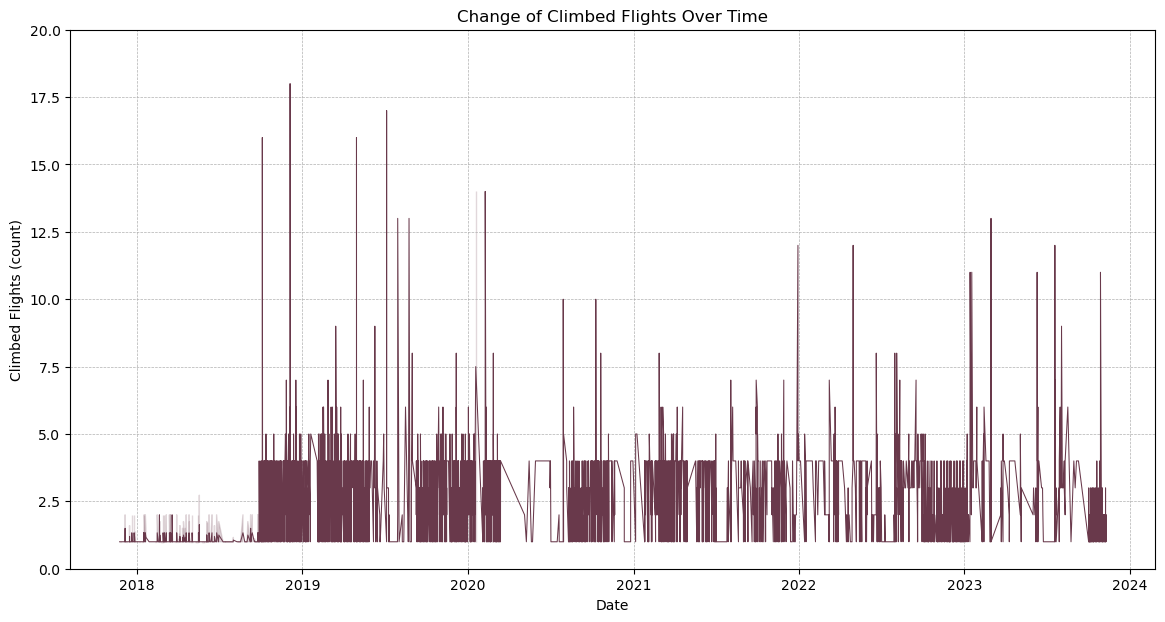

In [49]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_climbed["creationDate"], y = my_climbed["value"], color = "#69394b", linewidth = 0.75)
plt.title('Change of Climbed Flights Over Time')
plt.ylim(0, 20)
plt.xlabel('Date')
plt.ylabel('Climbed Flights (' + my_climbed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


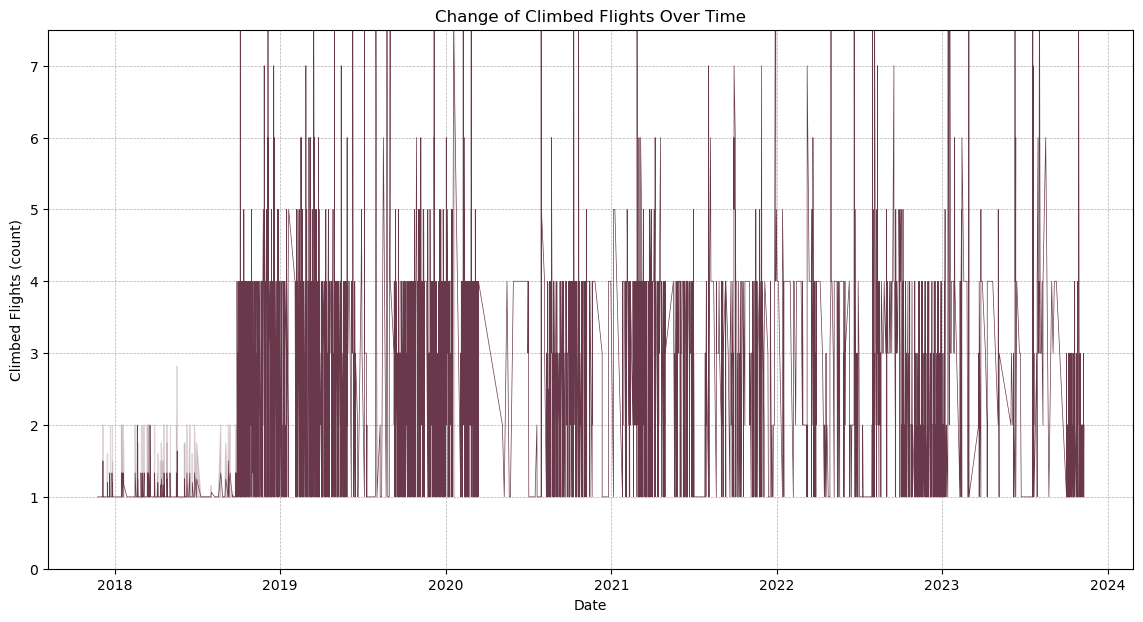

In [50]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_climbed["creationDate"], y = my_climbed["value"], color = "#69394b", linewidth = 0.5)
plt.title('Change of Climbed Flights Over Time')
plt.ylim(0, 7.5)
plt.xlabel('Date')
plt.ylabel('Climbed Flights (' + my_climbed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


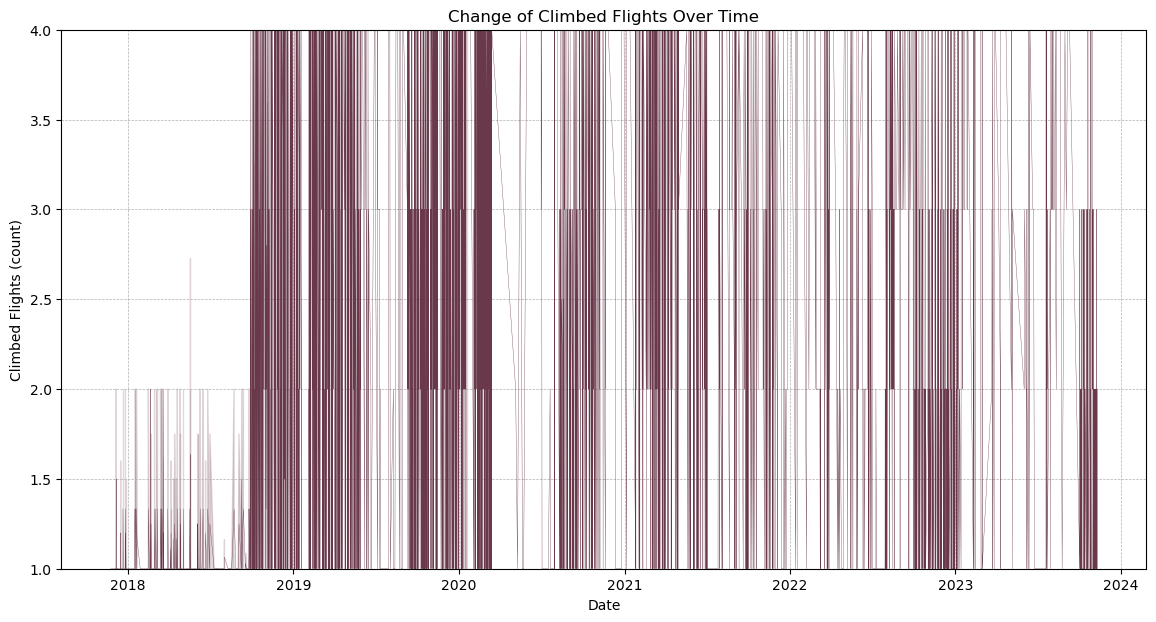

In [51]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_climbed["creationDate"], y = my_climbed["value"], color = "#69394b", linewidth = 0.25)
plt.title('Change of Climbed Flights Over Time')
plt.ylim(1, 4)
plt.xlabel('Date')
plt.ylabel('Climbed Flights (' + my_climbed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


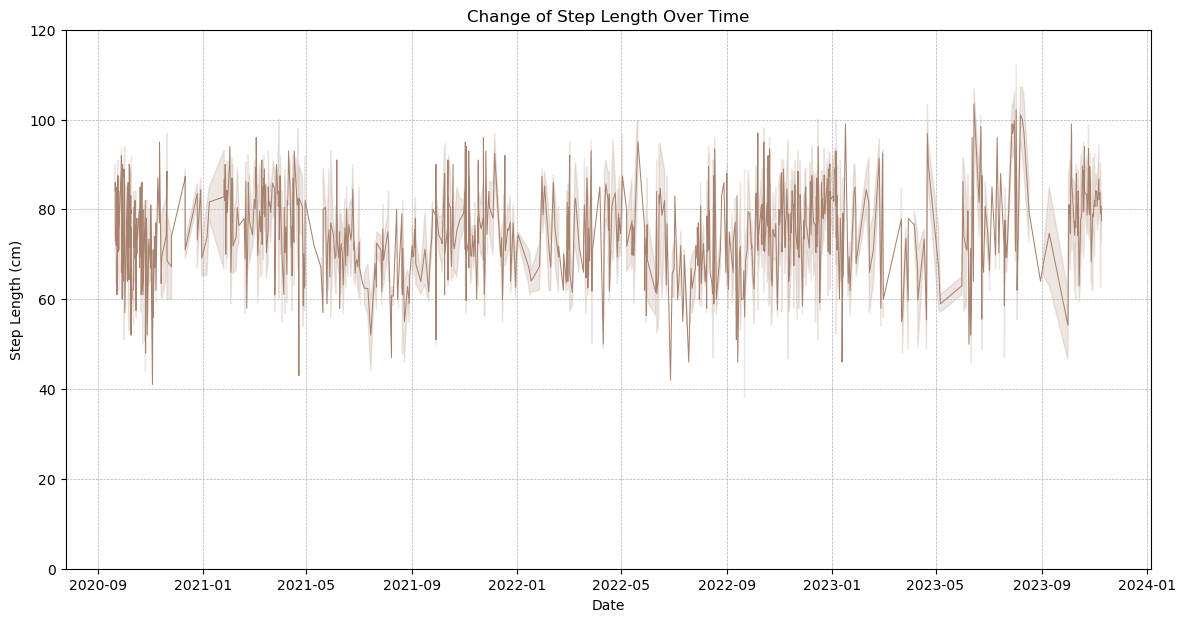

In [52]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_step_length["creationDate"], y = my_step_length["value"], color = "#a8826e", linewidth = 0.75)
plt.title('Change of Step Length Over Time')
plt.ylim(0, 120)
plt.xlabel('Date')
plt.ylabel('Step Length (' + my_step_length["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


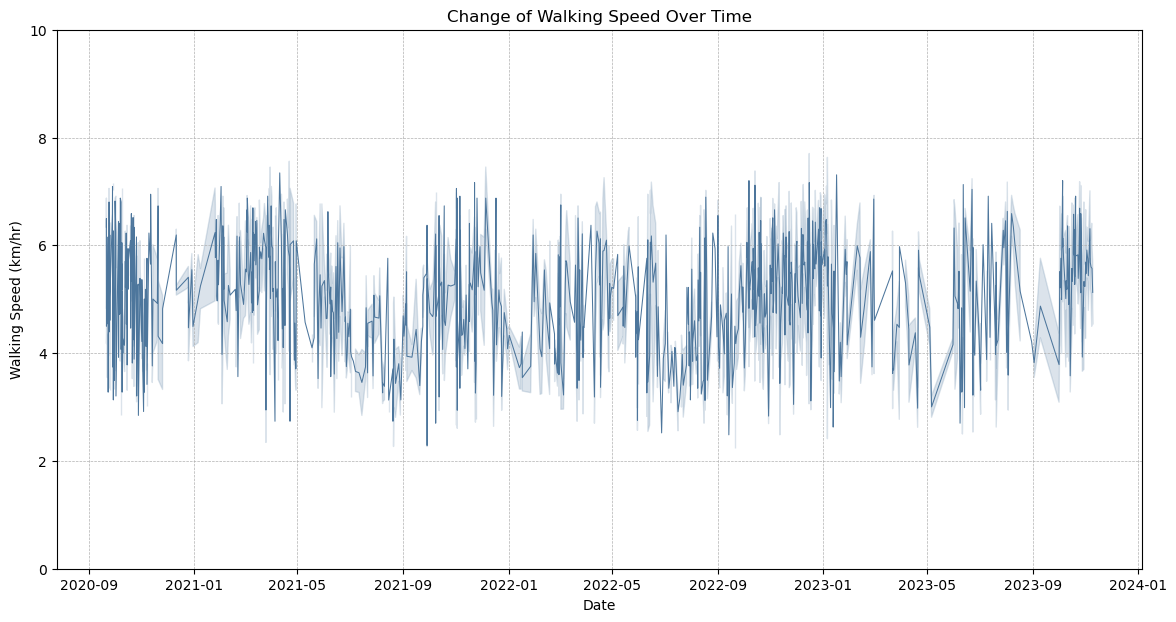

In [53]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_walking_speed["creationDate"], y = my_walking_speed["value"], color = "#4d769c", linewidth = 0.75)
plt.title('Change of Walking Speed Over Time')
plt.ylim(0, 10)
plt.xlabel('Date')
plt.ylabel('Walking Speed (' + my_walking_speed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


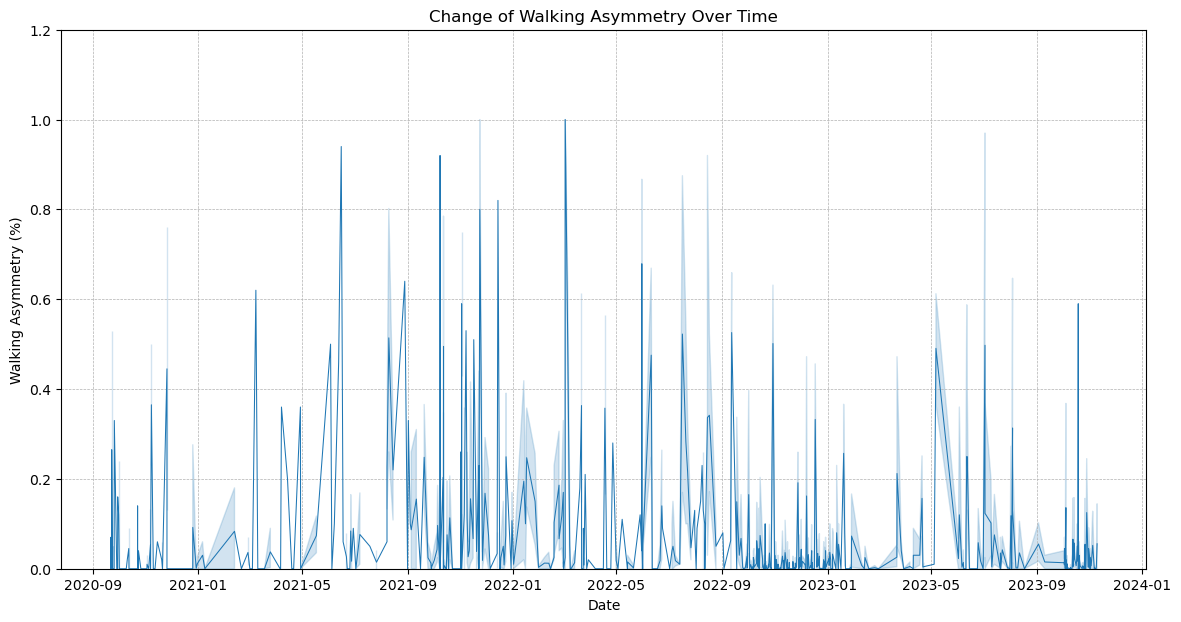

In [54]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_walking_asymmetry["creationDate"], y = my_walking_asymmetry["value"], linewidth = 0.75)
plt.title('Change of Walking Asymmetry Over Time')
plt.ylim(0, 1.2)
plt.xlabel('Date')
plt.ylabel('Walking Asymmetry (' + my_walking_asymmetry["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


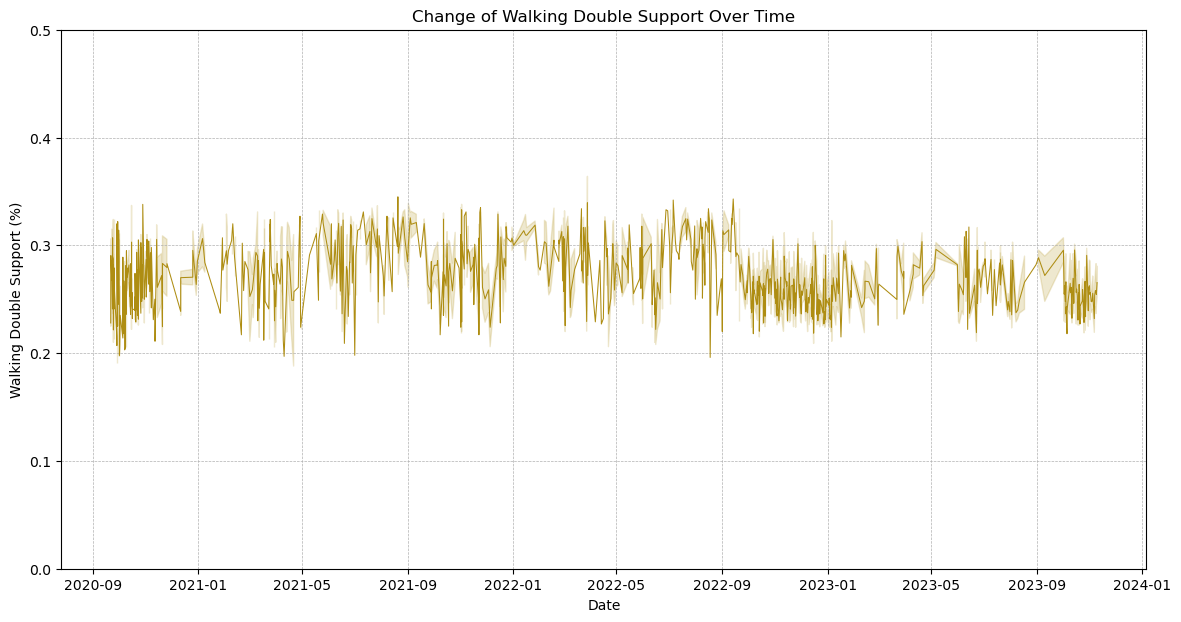

In [55]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_walking_double_support["creationDate"], y = my_walking_double_support["value"], color = "#ae8d12", linewidth = 0.75)
plt.title('Change of Walking Double Support Over Time')
plt.ylim(0, 0.5)
plt.xlabel('Date')
plt.ylabel('Walking Double Support (' + my_walking_double_support["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


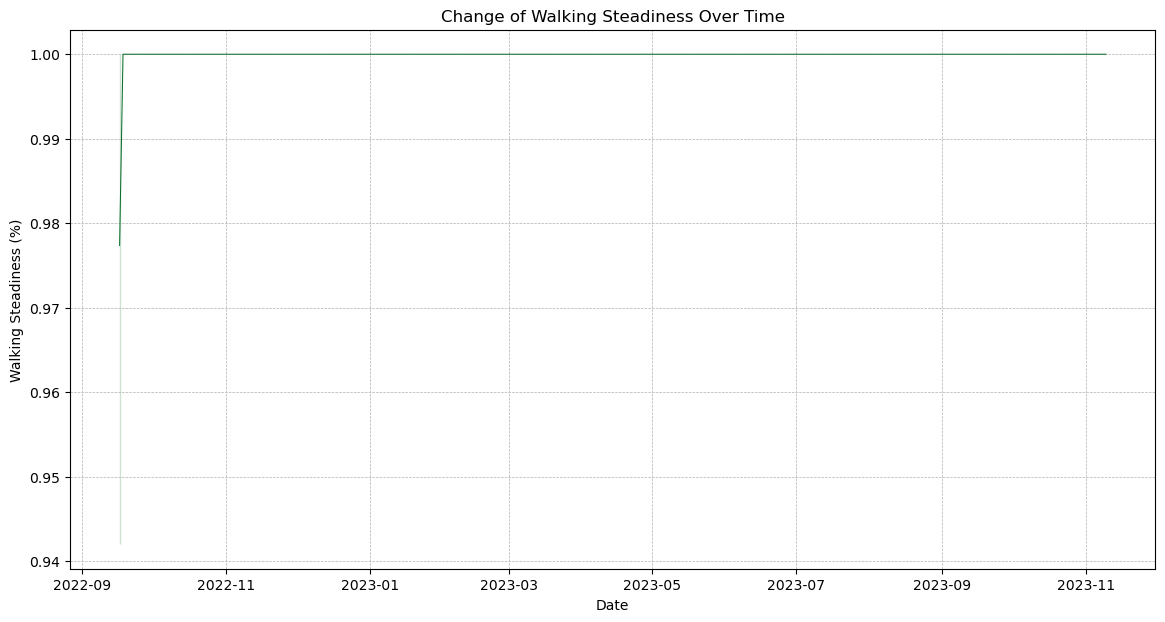

In [56]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_walking_steady["creationDate"], y = my_walking_steady["value"], color = "#0b6e2a", linewidth = 0.75)
plt.title('Change of Walking Steadiness Over Time')
plt.xlabel('Date')
plt.ylabel('Walking Steadiness (' + my_walking_steady["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Dataframes related to burned energy statistics

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


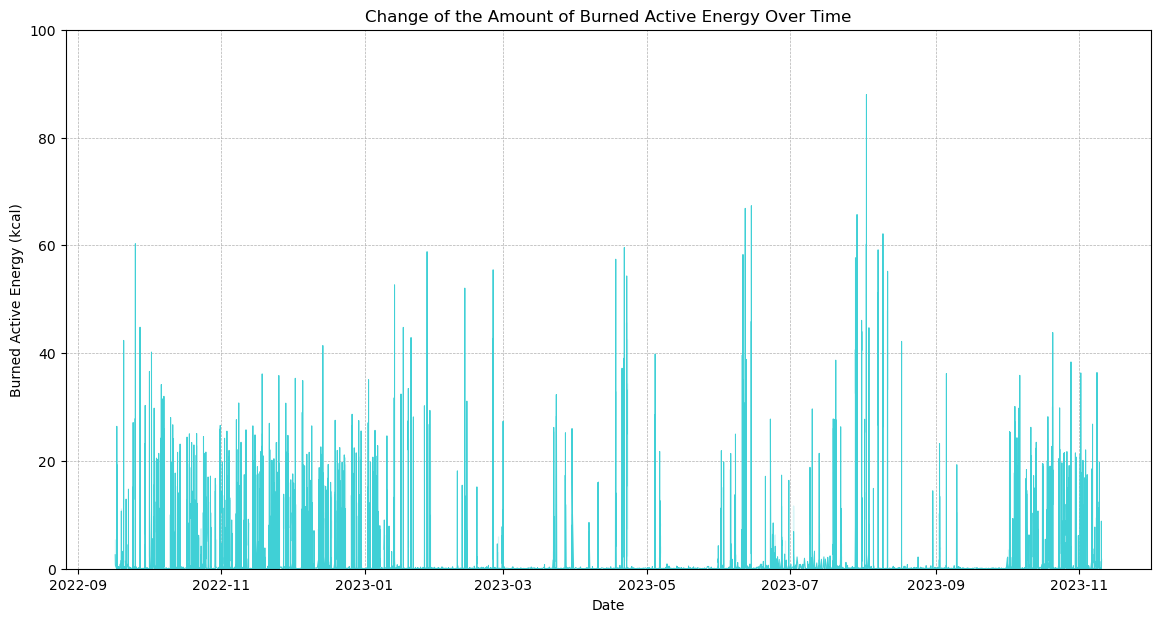

In [57]:
plt.figure(figsize = (14, 7))
sns.lineplot(x = my_active_energy["creationDate"], y = my_active_energy["value"], color = "#40d0d6", linewidth = 0.75)
plt.title('Change of the Amount of Burned Active Energy Over Time')
plt.ylim(0, 100)
plt.xlabel('Date')
plt.ylabel('Burned Active Energy (' + my_active_energy["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


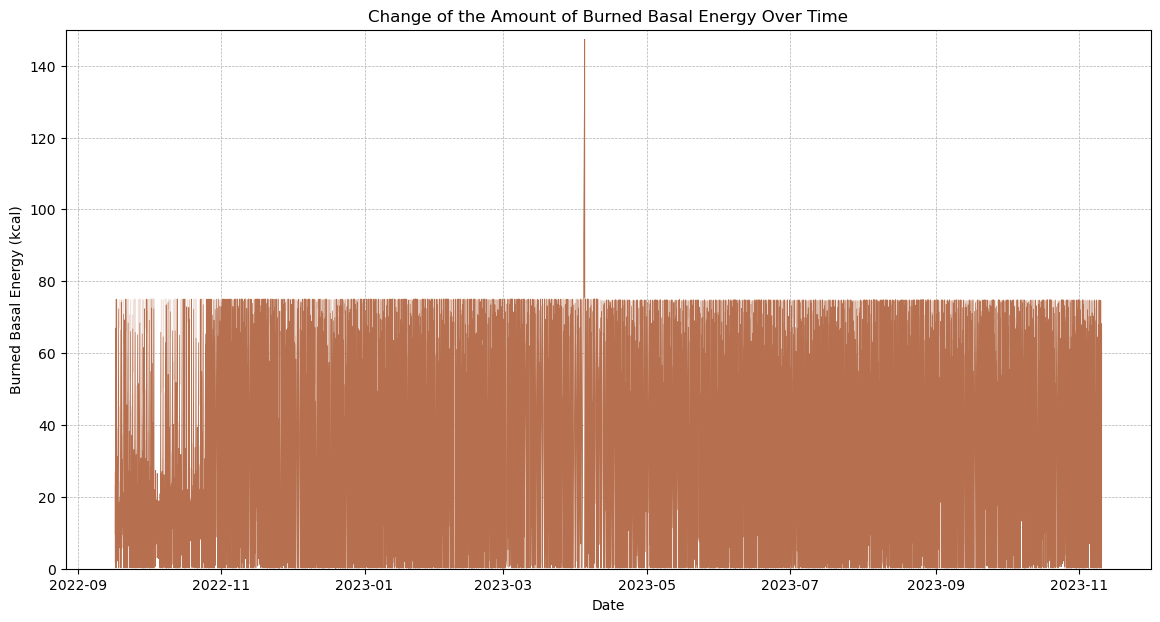

In [58]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_basal_energy["creationDate"], y = my_basal_energy["value"], color = "#b6704f", linewidth = 0.5)
plt.title('Change of the Amount of Burned Basal Energy Over Time')
plt.ylim(0, 150)
plt.xlabel('Date')
plt.ylabel('Burned Basal Energy (' + my_basal_energy["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


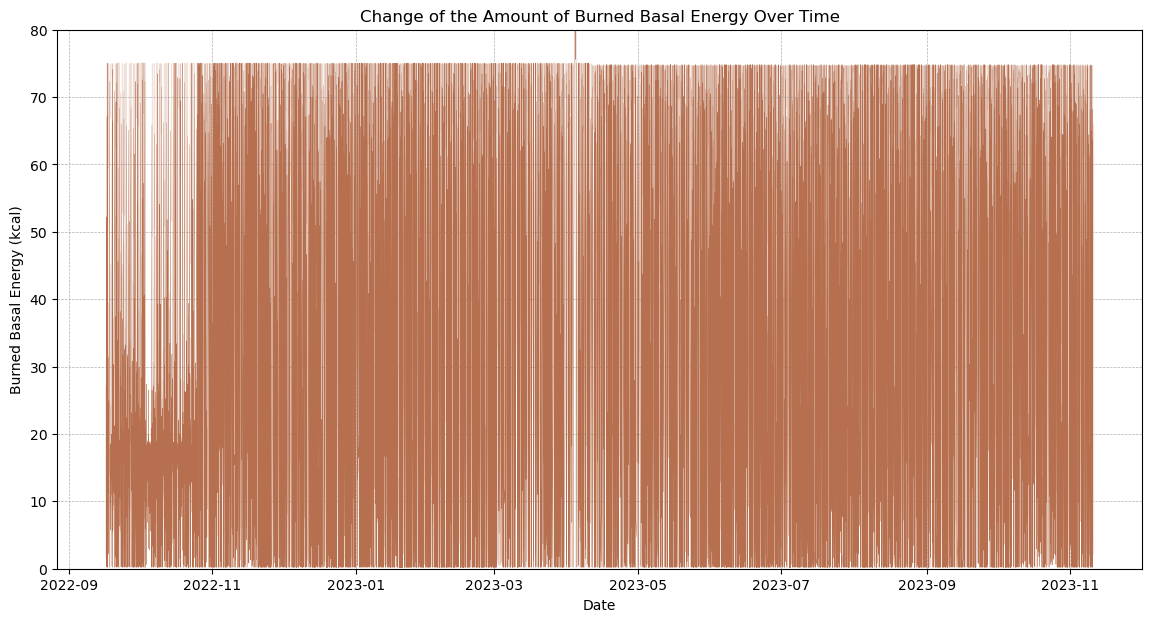

In [59]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_basal_energy["creationDate"], y = my_basal_energy["value"], color = "#b6704f", linewidth = 0.25)
plt.title('Change of the Amount of Burned Basal Energy Over Time')
plt.ylim(0, 80)
plt.xlabel('Date')
plt.ylabel('Burned Basal Energy (' + my_basal_energy["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Dataframes related to headphone audio statistics

/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/onurorman/anaconda3/envs/data_ai/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


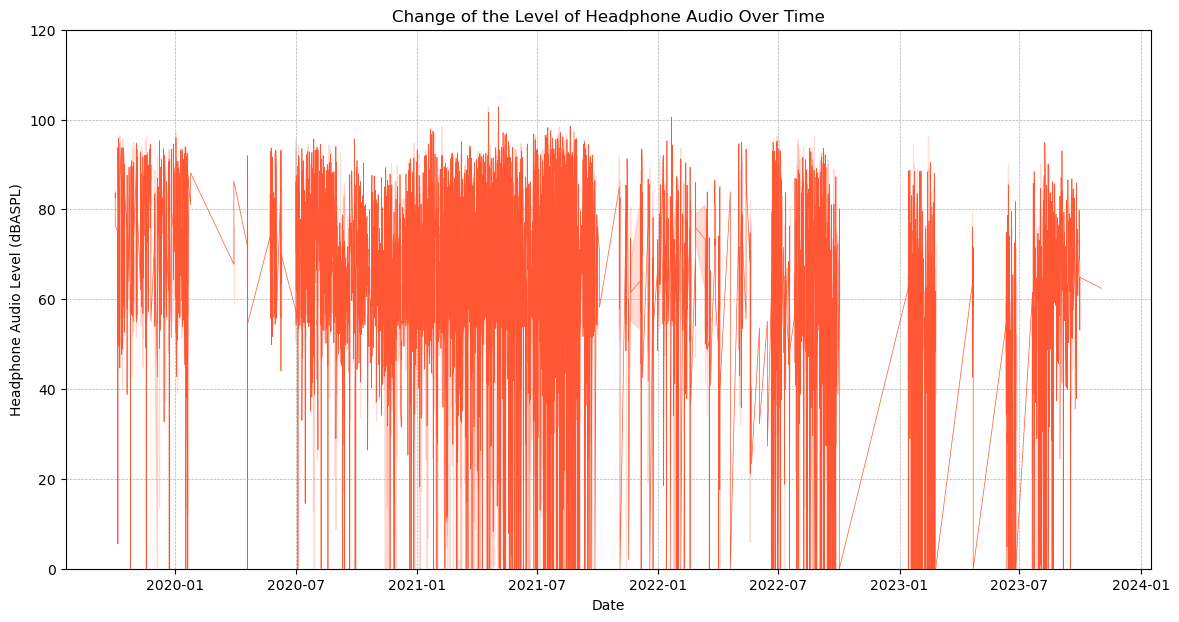

In [60]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = my_headphone_audio["creationDate"], y = my_headphone_audio["value"], color = "#FF5733", legend = False, linewidth = 0.5)
plt.title('Change of the Level of Headphone Audio Over Time')
plt.ylim(0, 120)
plt.xlabel('Date')
plt.ylabel('Headphone Audio Level (' + my_headphone_audio["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Some relations between different categories of data

#### The relationship between the step counts and the walking and running distance

The scatter plot demonstrating the relationship (including outliers)

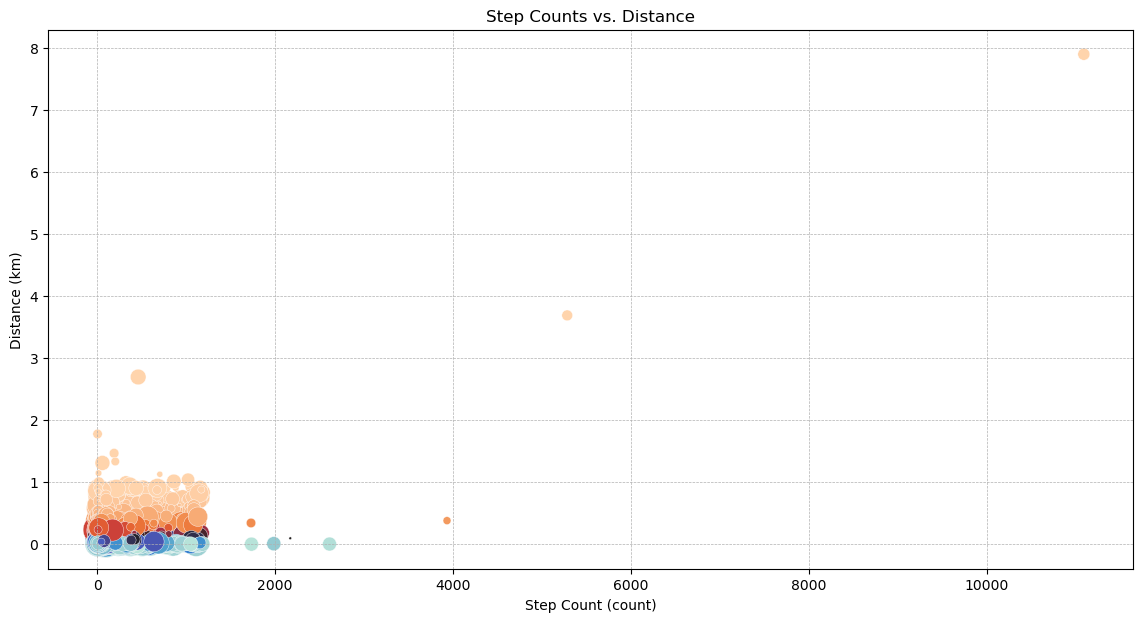

In [61]:
random_colors = sns.color_palette("icefire", n_colors = 11562)
rand_s = np.abs(np.random.randn(min(len(my_steps), len(my_distances)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps["value"], y = my_distances["value"], marker='o', palette = random_colors, hue = my_distances["value"], s = rand_s, legend = False)
plt.title('Step Counts vs. Distance')
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Distance (" + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

The scatter plot demonstrating the relationship (not including outliers)

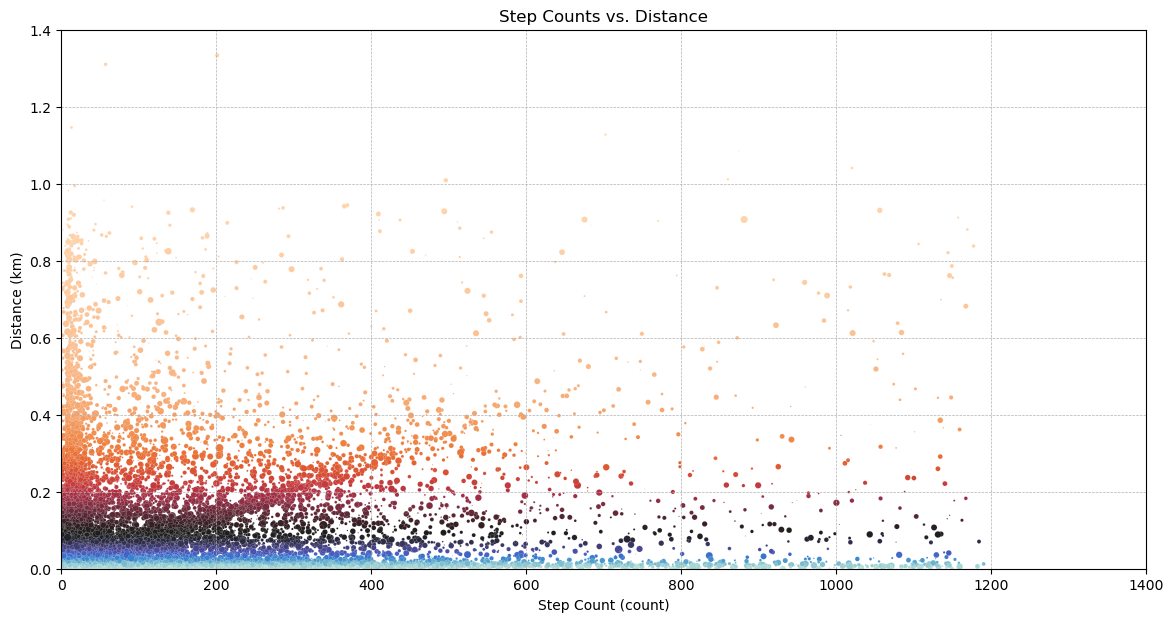

In [62]:
random_colors = sns.color_palette("icefire", n_colors = 11562)
rand_s = np.abs(np.random.randn(min(len(my_steps), len(my_distances)))) * 10
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps["value"], y = my_distances["value"], marker='o', palette = random_colors, hue = my_distances["value"], s = rand_s, legend = False)
plt.title('Step Counts vs. Distance')
plt.xlim(0, 1400)
plt.ylim(0, 1.4)
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Distance (" + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### The relationship between the step length and the step counts (supported after iOS 14)

The scatter plot demonstrating the relationship

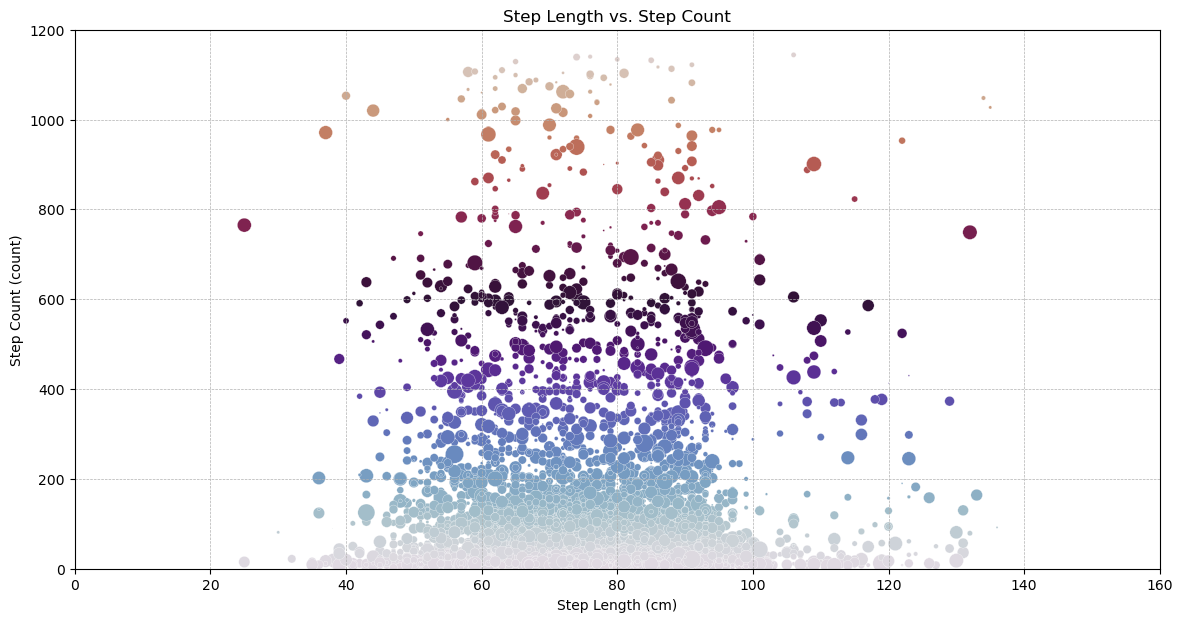

In [63]:
random_colors = sns.color_palette("twilight", as_cmap= True, n_colors = min(len(my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])), len(my_step_length)))
rand_s = np.abs(np.random.randn(min(len(my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])), len(my_step_length)))) * 50
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_step_length["value"], y = my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], marker='o', palette = random_colors, hue = my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], s = rand_s, legend = False)
plt.title('Step Length vs. Step Count')
plt.xlim(0, 160)
plt.ylim(0, 1200)
plt.xlabel("Step Length (" + my_step_length["unit"][0] + ")")
plt.ylabel("Step Count (" + my_steps["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### The relationship between the step length and the walking and running distance (supported after iOS 14)

The scatter plot demonstrating the relationship

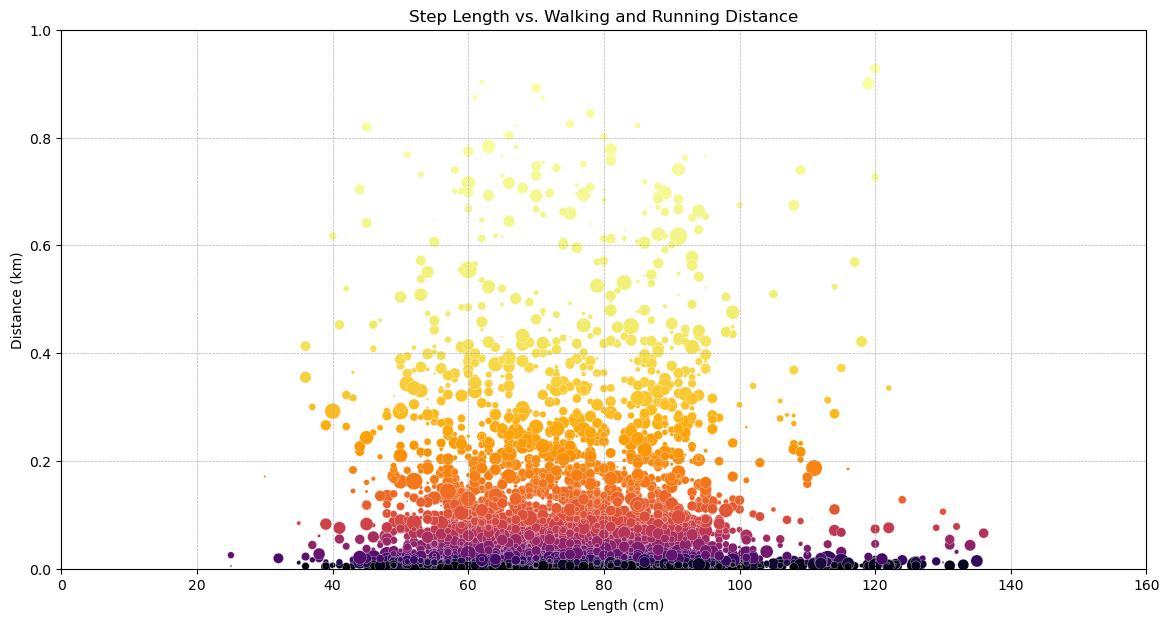

In [64]:
random_colors = sns.color_palette("inferno", n_colors = 6099)
rand_s = np.abs(np.random.randn(min(len(my_distances[my_distances["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])), len(my_step_length)))) * 50
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_step_length["value"], y = my_distances[my_distances["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], marker='o', palette = random_colors, hue = my_distances[my_distances["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], s = rand_s, legend = False)
plt.title('Step Length vs. Walking and Running Distance')
plt.ylim(0, 1)
plt.xlim(0, 160)
plt.xlabel("Step Length (" + my_step_length["unit"][0] + ")")
plt.ylabel("Distance (" + my_distances["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between step counts and burned active energy (supported after iOS 16)

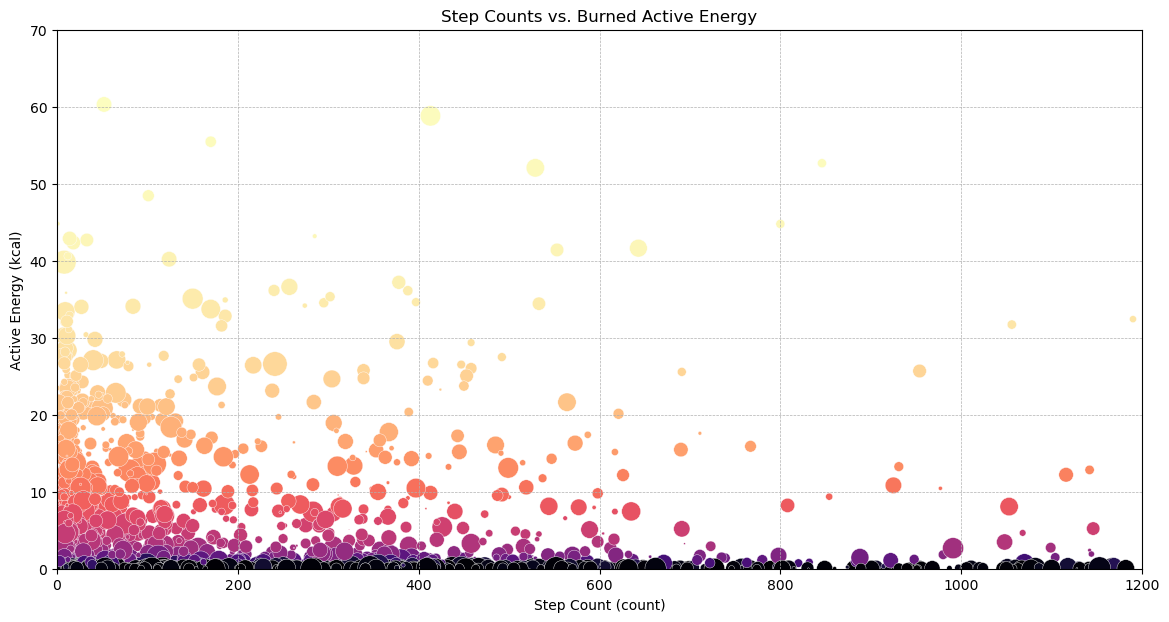

In [65]:
random_colors = sns.color_palette("magma", n_colors = 2469)
rand_s = np.abs(np.random.randn(min(len(my_steps[my_steps["sourceVersion"] >= 16].reset_index().drop(columns = ["index"])), len(my_active_energy)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps[my_steps["sourceVersion"] >= 16].reset_index().drop(columns = ["index"])["value"], y = my_active_energy["value"], marker='o', palette = random_colors, hue = my_active_energy["value"], s = rand_s, legend = False)
plt.title('Step Counts vs. Burned Active Energy')
plt.xlim(0, 1200)
plt.ylim(0, 70)
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Active Energy (" + my_active_energy["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between step counts and headphone audio level (supported after iOS 13.1)

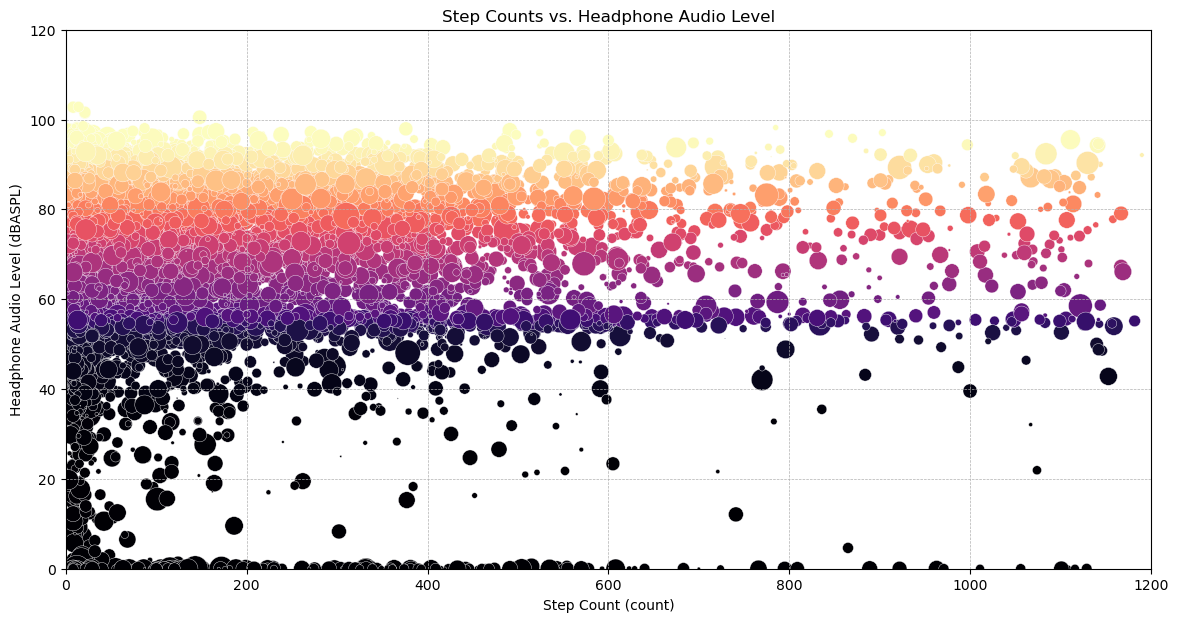

In [66]:
random_colors = sns.color_palette("magma", n_colors = 16295)
rand_s = np.abs(np.random.randn(min(len(my_steps[my_steps["sourceVersion"] >= 13.1].reset_index().drop(columns = ["index"])), len(my_headphone_audio)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps[my_steps["sourceVersion"] >= 13.1].reset_index().drop(columns = ["index"])["value"], y = my_headphone_audio["value"], marker='o', palette = random_colors, hue = my_headphone_audio["value"], s = rand_s, legend = False)
plt.title('Step Counts vs. Headphone Audio Level')
plt.xlim(0, 1200)
plt.ylim(0, 120)
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Headphone Audio Level (" + my_headphone_audio["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between step counts and walking speed (supported after iOS 14)

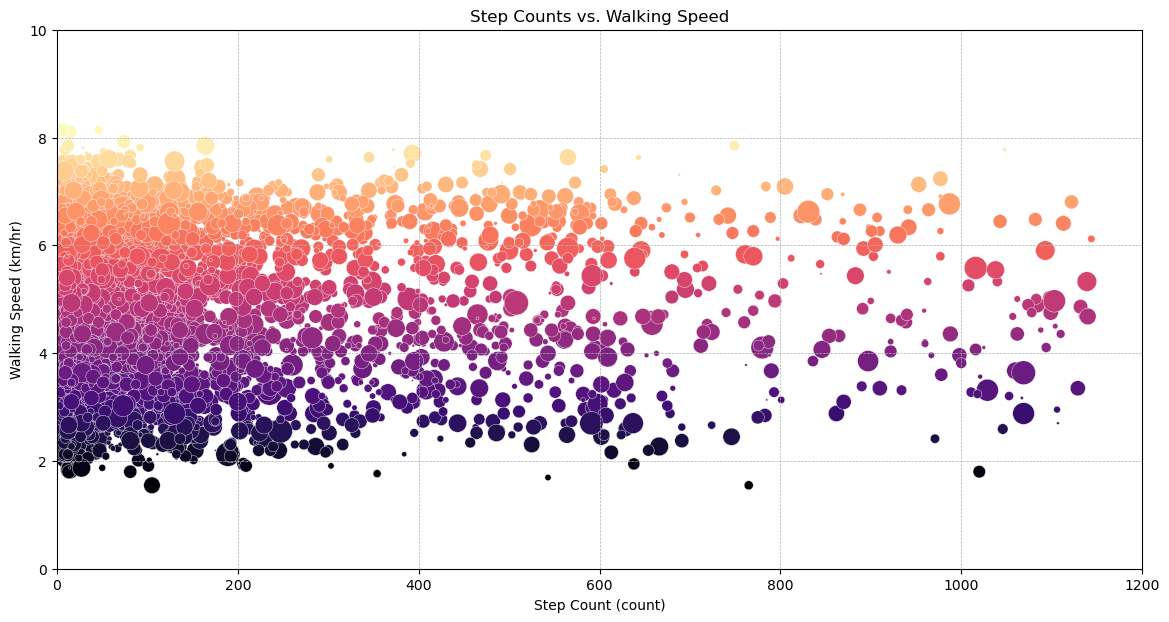

In [67]:
random_colors = sns.color_palette("magma", n_colors = 178)
rand_s = np.abs(np.random.randn(min(len(my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])), len(my_walking_speed)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps[my_steps["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], y = my_walking_speed["value"], marker='o', palette = random_colors, hue = my_walking_speed["value"], s = rand_s, legend = False)
plt.title('Step Counts vs. Walking Speed')
plt.xlim(0, 1200)
plt.ylim(0, 10)
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Walking Speed (" + my_walking_speed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between walking and running distances and walking speed (supported after iOS 14)

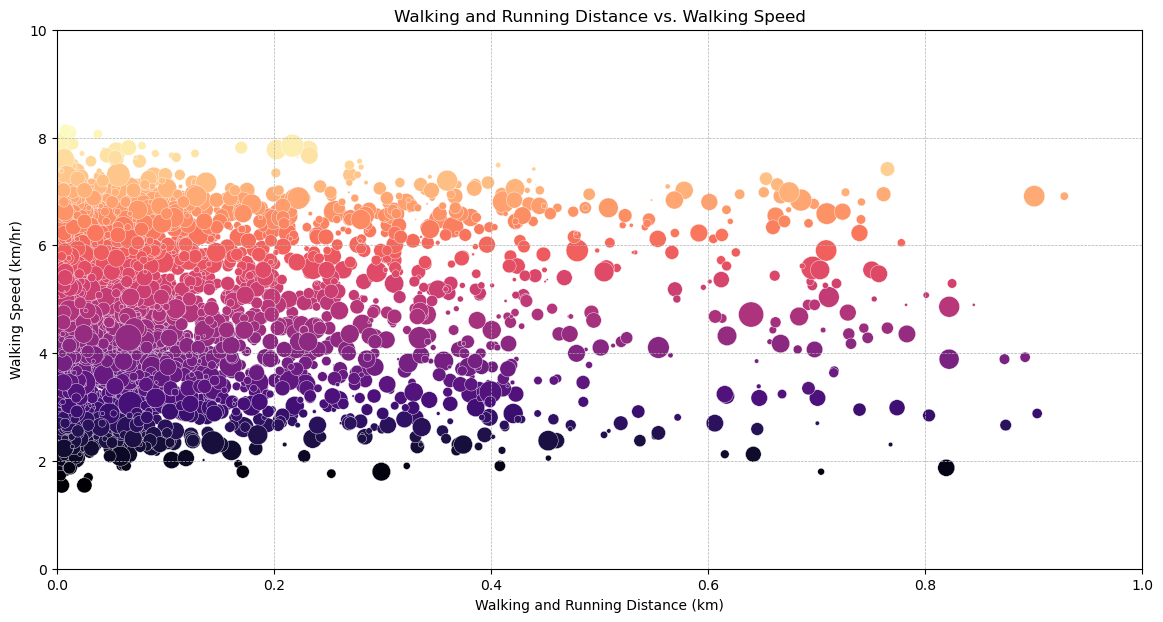

In [69]:
random_colors = sns.color_palette("magma", n_colors = 178)
rand_s = np.abs(np.random.randn(min(len(my_distances[my_distances["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])), len(my_walking_speed)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_distances[my_distances["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], y = my_walking_speed["value"], marker='o', palette = random_colors, hue = my_walking_speed["value"], s = rand_s, legend = False)
plt.title('Walking and Running Distance vs. Walking Speed')
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.xlabel("Walking and Running Distance (" + my_distances["unit"][0] + ")")
plt.ylabel("Walking Speed (" + my_walking_speed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between step count and climbed flights

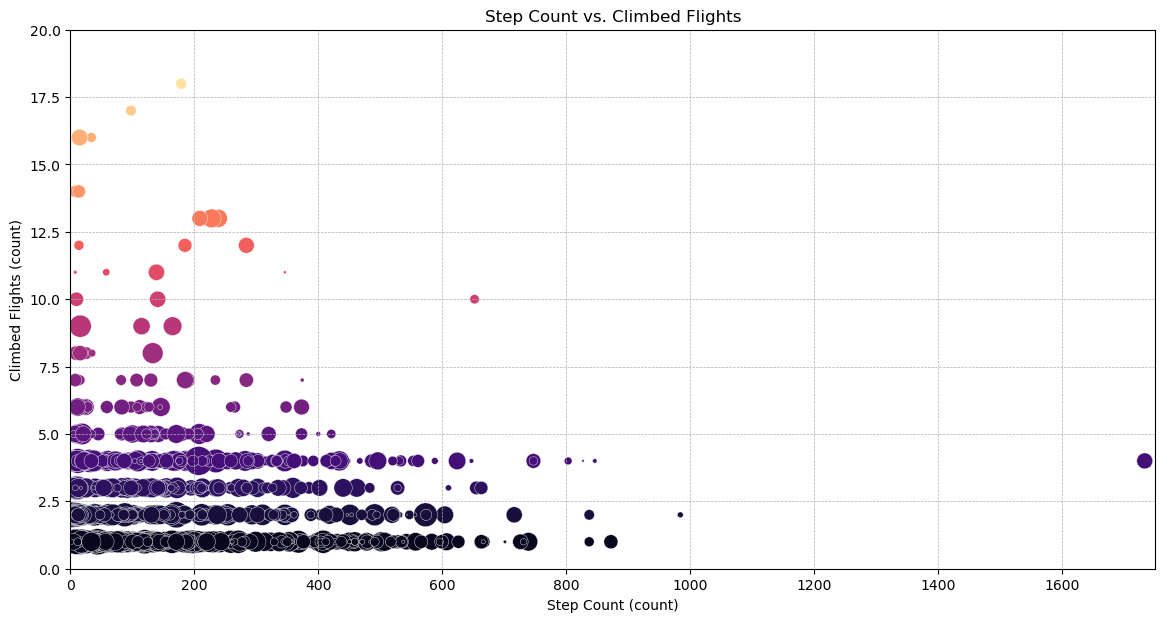

In [72]:
random_colors = sns.color_palette("magma", n_colors = 17)
rand_s = np.abs(np.random.randn(min(len(my_steps), len(my_climbed)))) * 100
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_steps["value"], y = my_climbed["value"], marker='o', palette = random_colors, hue = my_climbed["value"], s = rand_s, legend = False)
plt.title('Step Count vs. Climbed Flights')
plt.xlim(0, 1750)
plt.ylim(0, 20)
plt.xlabel("Step Count (" + my_steps["unit"][0] + ")")
plt.ylabel("Climbed Flights (" + my_climbed["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### The relationship between walking speed and headphone audio level (supported after iOS 14)

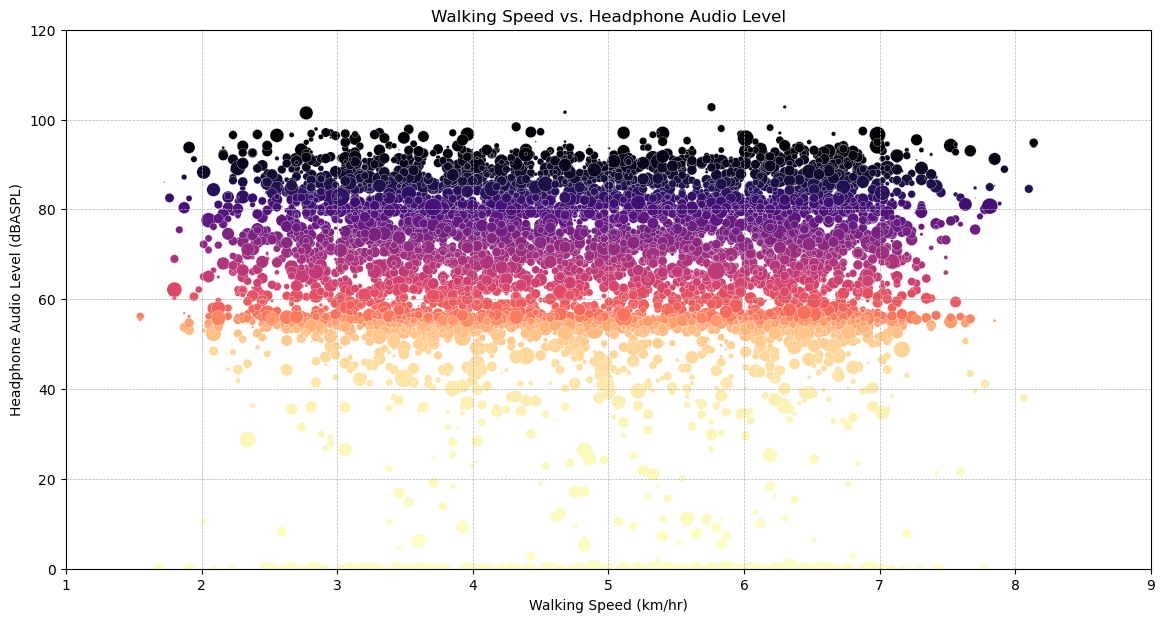

In [79]:
random_colors = sns.color_palette("magma_r", n_colors = 13485)
rand_s = np.abs(np.random.randn(min(len(my_walking_speed), len(my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"]))))) * 50
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_walking_speed["value"], y = my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], marker='o', palette = random_colors, hue = my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], s = rand_s, legend = False)
plt.title('Walking Speed vs. Headphone Audio Level')
plt.xlim(1, 9)
plt.ylim(0, 120)
plt.xlabel("Walking Speed (" + my_walking_speed["unit"][0] + ")")
plt.ylabel("Headphone Audio Level (" + my_headphone_audio["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Relationship between step length and headphone audio level (supported after iOS 14)

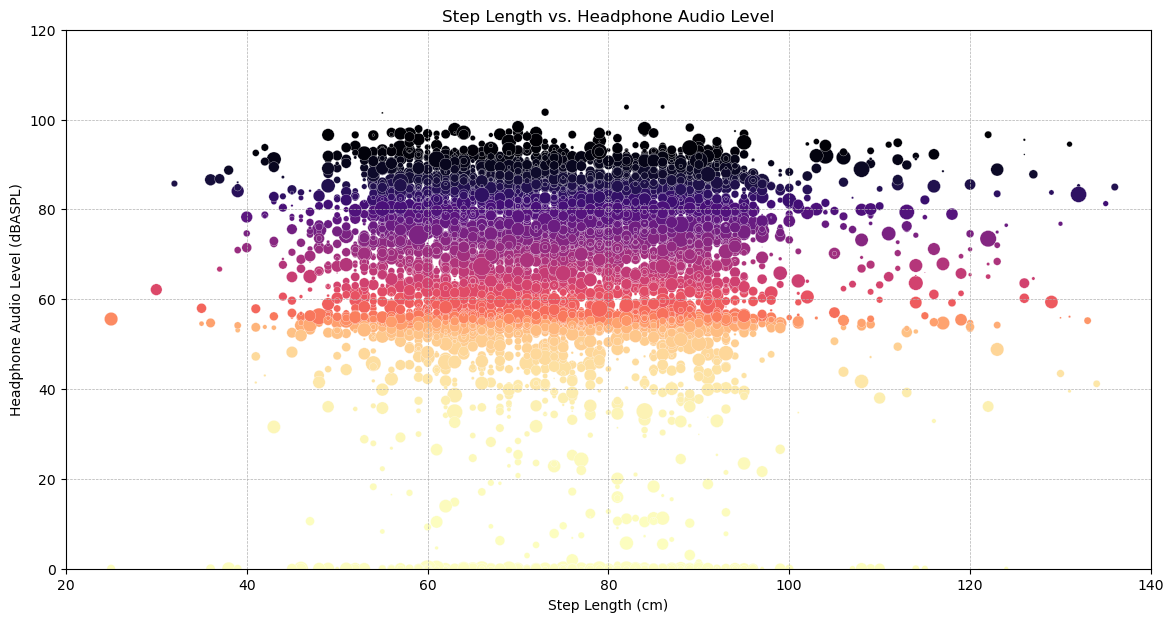

In [82]:
random_colors = sns.color_palette("magma_r", n_colors = 13485)
rand_s = np.abs(np.random.randn(min(len(my_step_length), len(my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"]))))) * 50
plt.figure(figsize = (14, 7))
sns.scatterplot(x = my_step_length["value"], y = my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], marker='o', palette = random_colors, hue = my_headphone_audio[my_headphone_audio["sourceVersion"] >= 14].reset_index().drop(columns = ["index"])["value"], s = rand_s, legend = False)
plt.title('Step Length vs. Headphone Audio Level')
plt.xlim(20, 140)
plt.ylim(0, 120)
plt.xlabel("Step Length (" + my_step_length["unit"][0] + ")")
plt.ylabel("Headphone Audio Level (" + my_headphone_audio["unit"][0] + ")")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()